# Overview

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In [5]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time

%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from glob import glob
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report


from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [7]:
df_app_test = pd.read_csv('source/application_test.csv',sep=',')
df_app_train = pd.read_csv('source/application_train.csv',sep=',')
df_bureau = pd.read_csv('source/bureau.csv',sep=',')
df_bureau_balance = pd.read_csv('source/bureau_balance.csv',sep=',')
df_credit_card_balance = pd.read_csv('source/credit_card_balance.csv',sep=',')
df_installments_payments = pd.read_csv('source/installments_payments.csv',sep=',')
df_POS_CASH_balance = pd.read_csv('source/POS_CASH_balance.csv',sep=',')
df_previous_application = pd.read_csv('source/previous_application.csv',sep=',')
df_sample_submission = pd.read_csv('source/sample_submission.csv',sep=',')

In [8]:
df_HomeCredit_description = pd.read_csv('source/homeCredit.csv',sep=';')
df_HomeCredit_description = df_HomeCredit_description.loc[:,['Table','Row','Description','Special"']]

# 1. Nettoyage des données

# df test

In [9]:
df_app_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [10]:
print('AMT_INCOME_TOTAL : ',df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'AMT_INCOME_TOTAL','Description'].values,
      '\nAMT_CREDIT : ' ,df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'AMT_CREDIT','Description'].values)

AMT_INCOME_TOTAL :  ['Income of the client'] 
AMT_CREDIT :  ['Credit amount of the loan'
 '""Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for']


In [11]:
df_app_test.isna().mean()

SK_ID_CURR                    0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.124097
AMT_REQ_CREDIT_BUREAU_WEEK    0.124097
AMT_REQ_CREDIT_BUREAU_MON     0.124097
AMT_REQ_CREDIT_BUREAU_QRT     0.124097
AMT_REQ_CREDIT_BUREAU_YEAR    0.124097
Length: 121, dtype: float64

# df train

In [12]:
df_app_train.iloc[:,:20]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0


In [13]:
df_app_train.columns[:50]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APART

In [14]:
df_app_train.columns[51:100]

Index(['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOC

In [15]:
df_app_train.columns[101:122]

Index(['FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [16]:
print('Valeur moyenne en pourcentage de nan :\n', df_app_train.isna().mean())
print('\ntoutes les variables qui ont une moyenne nan inférieure à 0.3')
cols_seuil_nan = df_app_train.isna().mean()[df_app_train.isna().mean() < 0.3]

Valeur moyenne en pourcentage de nan :
 SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 122, dtype: float64

toutes les variables qui ont une moyenne nan inférieure à 0.3


In [17]:
cols_seuil_nan = cols_seuil_nan.index
cols_seuil_nan

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       

In [18]:
for col in df_app_train.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)


variables SK_ID_CURR : ['ID of loan in our sample'
 '""ID of loan in our sample - one loan in our sample can have 0'
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

variables TARGET : ['""Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample']

variables NAME_CONTRACT_TYPE : ['Identification if loan is cash or revolving'
 '""Contract product type (Cash loan']

variables CODE_GENDER : ['Gender of the client']

variables FLAG_OWN_CAR : ['Flag if the client owns a car']

variables FLAG_OWN_REALTY : ['Flag if client owns a house or flat']

variables CNT_CHILDREN : ['Number of children the client has']

variables AMT_INCOME_TOTAL : ['Income of the client']

variables AMT_CREDIT : ['Credit amount of the loan'
 '""Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_A

## variables retenu pour l'analyse des données 

- TARGET : La variable cible indiquant si le client a eu des difficultés de paiement dans le passé est essentielle pour former un modèle de prédiction.

- AMT_INCOME_TOTAL : Le revenu du client est un facteur crucial pour évaluer sa capacité à rembourser le crédit.

- AMT_CREDIT : Le montant du crédit demandé par le client est une variable importante pour évaluer le risque de défaut de paiement.

- AMT_ANNUITY : L'annuité du crédit est un indicateur clé pour déterminer la capacité du client à faire face aux paiements périodiques.

- CODE_GENDER : Le genre du client peut être pris en compte dans le modèle, car il peut être lié à des comportements de remboursement différents.

- CNT_CHILDREN : Le nombre d'enfants du client peut influencer sa capacité de remboursement.

- NAME_EDUCATION_TYPE : Le niveau d'éducation du client peut également être un indicateur de sa stabilité financière.

- NAME_FAMILY_STATUS : Le statut familial du client peut être pris en compte, car il peut affecter les responsabilités financières du client.

- DAYS_BIRTH : L'âge du client peut être un facteur pertinent, car les comportements de remboursement peuvent varier selon l'âge.

- DAYS_EMPLOYED : Le nombre de jours depuis le début de l'emploi actuel du client peut être pris en compte pour évaluer la stabilité de son emploi.


- varibles EXT_SOURCE_1 : ['Normalized score from external data source']

- varibles EXT_SOURCE_2 : ['Normalized score from external data source']

- varibles EXT_SOURCE_3 : ['Normalized score from external data source']

In [19]:
cols= ['TARGET',
              'SK_ID_CURR',
              'AMT_INCOME_TOTAL',
              'AMT_CREDIT',
              'AMT_ANNUITY',
              'CNT_CHILDREN',
              'DAYS_BIRTH',
              'NAME_FAMILY_STATUS',
              'DAYS_EMPLOYED',
              'FLAG_OWN_CAR',
              'FLAG_OWN_REALTY',
              'EXT_SOURCE_1',
              'EXT_SOURCE_2',
              'EXT_SOURCE_3']

In [20]:
'''cols_train = ['TARGET',
              'AMT_INCOME_TOTAL',
              'AMT_CREDIT',
              'AMT_ANNUITY',
              'CODE_GENDER',
              'CNT_CHILDREN',
              'NAME_EDUCATION_TYPE',
              'NAME_FAMILY_STATUS',
              'DAYS_BIRTH',
              'DAYS_EMPLOYED',
              'EXT_SOURCE_1',
              'EXT_SOURCE_2',
              'EXT_SOURCE_3']'''

"cols_train = ['TARGET',\n              'AMT_INCOME_TOTAL',\n              'AMT_CREDIT',\n              'AMT_ANNUITY',\n              'CODE_GENDER',\n              'CNT_CHILDREN',\n              'NAME_EDUCATION_TYPE',\n              'NAME_FAMILY_STATUS',\n              'DAYS_BIRTH',\n              'DAYS_EMPLOYED',\n              'EXT_SOURCE_1',\n              'EXT_SOURCE_2',\n              'EXT_SOURCE_3']"

In [21]:
[print(f'value unique of {col} : ',df_app_train[col].unique()) for col in cols]

value unique of TARGET :  [1 0]
value unique of SK_ID_CURR :  [100002 100003 100004 ... 456253 456254 456255]
value unique of AMT_INCOME_TOTAL :  [202500.  270000.   67500.  ...  96768.  546250.5 113062.5]
value unique of AMT_CREDIT :  [ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]
value unique of AMT_ANNUITY :  [24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5]
value unique of CNT_CHILDREN :  [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
value unique of DAYS_BIRTH :  [ -9461 -16765 -19046 ...  -7951  -7857 -25061]
value unique of NAME_FAMILY_STATUS :  ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
value unique of DAYS_EMPLOYED :  [  -637  -1188   -225 ... -12971 -11084  -8694]
value unique of FLAG_OWN_CAR :  ['N' 'Y']
value unique of FLAG_OWN_REALTY :  ['Y' 'N']
value unique of EXT_SOURCE_1 :  [0.08303697 0.31126731        nan ... 0.14557045 0.7440264  0.73445967]
value unique of EXT_SOURCE_2 :  [0.26294859 0.62224578 0.555912

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [22]:
df_app_train2 = df_app_train.loc[:,cols]
#msno.matrix(df_app_train2)

In [23]:
df_app_train2.NAME_FAMILY_STATUS.unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [24]:
df_app_train2

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,Single / not married,-637,N,Y,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,Married,-1188,N,N,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,Single / not married,-225,Y,Y,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,Civil marriage,-3039,N,Y,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,Single / not married,-3038,N,Y,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,Separated,-236,N,N,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,Widow,365243,N,Y,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,Separated,-7921,N,Y,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,Married,-4786,N,Y,NaN,0.514163,0.661024


## traitement des valeurs manquantes

In [25]:
for col in df_app_train2.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)


variables TARGET : ['""Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample']

variables SK_ID_CURR : ['ID of loan in our sample'
 '""ID of loan in our sample - one loan in our sample can have 0'
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

variables AMT_INCOME_TOTAL : ['Income of the client']

variables AMT_CREDIT : ['Credit amount of the loan'
 '""Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for']

variables AMT_ANNUITY : ['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']

variables CNT_CHILDREN : ['Number of children the client has']

variables DAYS_BIRTH : ["Client's age in days at the time of application"]

variables NAME_FAMILY_STATUS : ['Fa

In [26]:
df_app_train2.isna().mean()

TARGET                0.000000
SK_ID_CURR            0.000000
AMT_INCOME_TOTAL      0.000000
AMT_CREDIT            0.000000
AMT_ANNUITY           0.000039
CNT_CHILDREN          0.000000
DAYS_BIRTH            0.000000
NAME_FAMILY_STATUS    0.000000
DAYS_EMPLOYED         0.000000
FLAG_OWN_CAR          0.000000
FLAG_OWN_REALTY       0.000000
EXT_SOURCE_1          0.563811
EXT_SOURCE_2          0.002146
EXT_SOURCE_3          0.198253
dtype: float64

In [27]:
'''X_cat = df_app_train2.select_dtypes(exclude=np.number)
df_categorial = pd.get_dummies(X_cat)
df_categorial'''

'X_cat = df_app_train2.select_dtypes(exclude=np.number)\ndf_categorial = pd.get_dummies(X_cat)\ndf_categorial'

In [28]:
from sklearn.preprocessing import LabelEncoder

def encodage_variable(col, df):
    
    enc = LabelEncoder()
    
    X = df[col]

    X_enc = enc.fit_transform(X)

    X_enc

    df[col] = X_enc
    
    return df

In [29]:
df_app_train2 = encodage_variable('FLAG_OWN_REALTY', df_app_train2)


In [30]:
df_app_train2 = encodage_variable('FLAG_OWN_CAR', df_app_train2)
df_app_train2

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,Single / not married,-637,0,1,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,Married,-1188,0,0,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,Single / not married,-225,1,1,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,Civil marriage,-3039,0,1,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,Single / not married,-3038,0,1,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,Separated,-236,0,0,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,Widow,365243,0,1,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,Separated,-7921,0,1,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,Married,-4786,0,1,NaN,0.514163,0.661024


In [31]:
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Single / not married','NAME_FAMILY_STATUS'] = 0
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Separated','NAME_FAMILY_STATUS'] = 0
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Widow','NAME_FAMILY_STATUS'] = 0
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Married','NAME_FAMILY_STATUS'] = 1
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Civil marriage','NAME_FAMILY_STATUS'] = 1
df_app_train2.loc[df_app_train2.NAME_FAMILY_STATUS =='Unknown','NAME_FAMILY_STATUS'] = 1



In [32]:
df_app_train2.NAME_FAMILY_STATUS.unique()

array([0, 1], dtype=object)

## Supression des valeurs manquantes et outliers

<Axes: xlabel='TARGET', ylabel='AMT_CREDIT'>

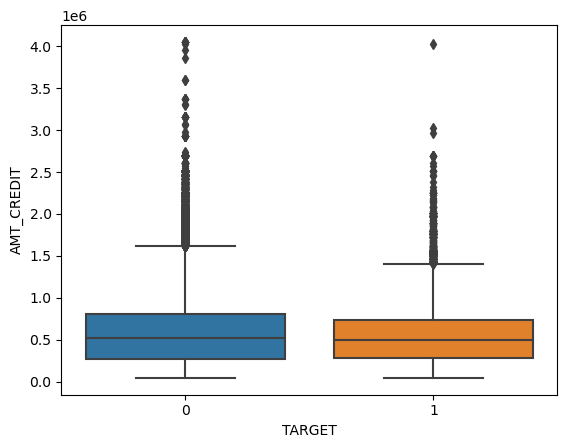

In [33]:
sns.boxplot(data = df_app_train2, x = 'TARGET', y='AMT_CREDIT')

<Axes: xlabel='TARGET', ylabel='AMT_CREDIT'>

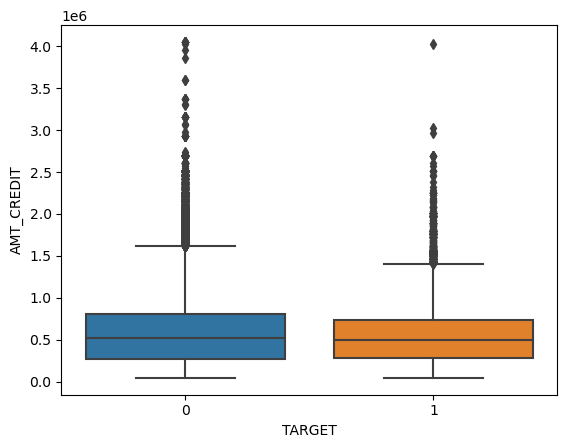

In [34]:
sns.boxplot(data = df_app_train2, x = 'TARGET', y='AMT_CREDIT')

<Axes: xlabel='TARGET', ylabel='AMT_ANNUITY'>

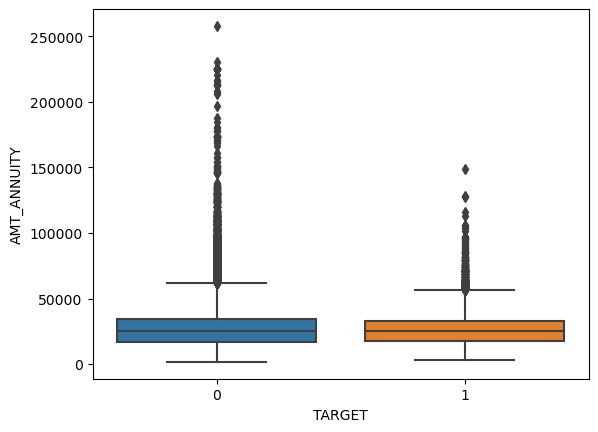

In [35]:
sns.boxplot(data = df_app_train2, x = 'TARGET', y='AMT_ANNUITY')

In [36]:
df_app_train2.loc[df_app_train2.AMT_ANNUITY <= 50000]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637,0,1,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,1,-1188,0,0,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,0,-225,1,1,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,1,-3039,0,1,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,0,-3038,0,1,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,0,-236,0,0,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,0,365243,0,1,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,0,-7921,0,1,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,1,-4786,0,1,NaN,0.514163,0.661024


<Axes: xlabel='TARGET', ylabel='AMT_ANNUITY'>

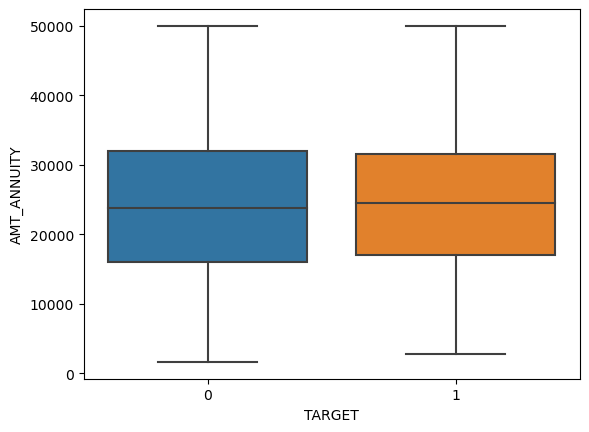

In [37]:
sns.boxplot(data = df_app_train2.loc[df_app_train2.AMT_ANNUITY <= 50000], x = 'TARGET', y='AMT_ANNUITY')

In [38]:
df_app_train2 =  df_app_train2.loc[df_app_train2.AMT_ANNUITY <= 50000]

<Axes: xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

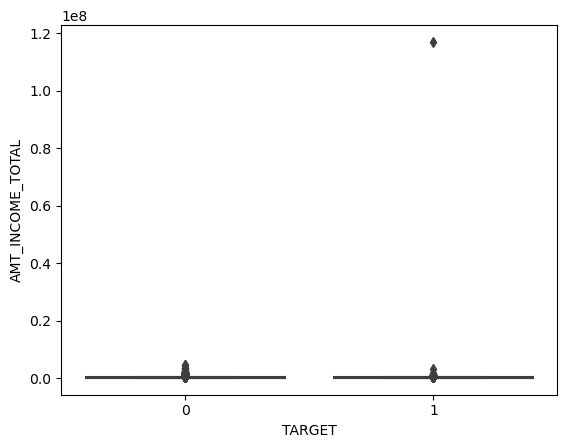

In [39]:
sns.boxplot(data = df_app_train2, x = 'TARGET', y='AMT_INCOME_TOTAL')

<Axes: xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

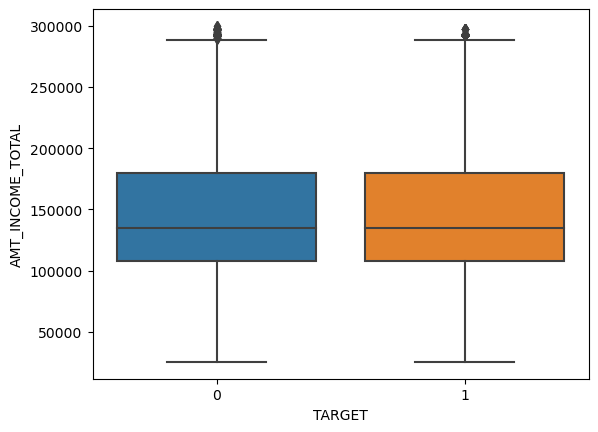

In [40]:
sns.boxplot(data = df_app_train2.loc[df_app_train2.AMT_INCOME_TOTAL <= 300000], x = 'TARGET', y='AMT_INCOME_TOTAL')

In [41]:
df_app_train2.loc[df_app_train2.AMT_INCOME_TOTAL <= 300000]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637,0,1,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,1,-1188,0,0,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,0,-225,1,1,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,1,-3039,0,1,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,0,-3038,0,1,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,0,-236,0,0,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,0,365243,0,1,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,0,-7921,0,1,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,1,-4786,0,1,NaN,0.514163,0.661024


In [42]:
df_app_train2 = df_app_train2.loc[df_app_train2.AMT_INCOME_TOTAL <= 300000]
df_app_train2

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637,0,1,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,1,-1188,0,0,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,0,-225,1,1,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,1,-3039,0,1,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,0,-3038,0,1,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,0,-236,0,0,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,0,365243,0,1,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,0,-7921,0,1,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,1,-4786,0,1,NaN,0.514163,0.661024


In [43]:
df_app_train2.AMT_INCOME_TOTAL.median(), df_app_train2.AMT_INCOME_TOTAL.max(),df_app_train2.AMT_INCOME_TOTAL.mean()

(135000.0, 299700.0, 146264.92426635054)

In [44]:
def imputed_by_mean(cols,df):
    mean = df[cols].mean()
    idx_nan = df[df[cols].isna() == True].index
    df[cols].loc[idx_nan] = mean

In [45]:
#df_app_train3 = pd.concat([df_app_train2,df_categorial], axis = 1)
df_app_train3 = df_app_train2
df_app_train3.isna().mean()

TARGET                0.000000
SK_ID_CURR            0.000000
AMT_INCOME_TOTAL      0.000000
AMT_CREDIT            0.000000
AMT_ANNUITY           0.000000
CNT_CHILDREN          0.000000
DAYS_BIRTH            0.000000
NAME_FAMILY_STATUS    0.000000
DAYS_EMPLOYED         0.000000
FLAG_OWN_CAR          0.000000
FLAG_OWN_REALTY       0.000000
EXT_SOURCE_1          0.573582
EXT_SOURCE_2          0.002273
EXT_SOURCE_3          0.201122
dtype: float64

In [46]:
mean_days_employed = df_app_train3.DAYS_EMPLOYED[df_app_train3.DAYS_EMPLOYED < 0].mean()
df_app_train3.DAYS_EMPLOYED[df_app_train3.DAYS_EMPLOYED > 0]

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 51722, dtype: int64

In [47]:
df_app_train3.DAYS_EMPLOYED[df_app_train3.DAYS_EMPLOYED > 0] = mean_days_employed
df_app_train3.DAYS_EMPLOYED[df_app_train3.DAYS_EMPLOYED > 0]

Series([], Name: DAYS_EMPLOYED, dtype: float64)

In [48]:
df_app_train3[df_app_train2.DAYS_BIRTH >0]
df_app_train3.DAYS_BIRTH.min(),df_app_train3.DAYS_BIRTH.max()

(-25201, -7489)

## Feature engenering

In [49]:
'''df_app_train3.DAYS_BIRTH = df_app_train3.DAYS_BIRTH/-365
df_app_train3.DAYS_EMPLOYED = df_app_train3.DAYS_EMPLOYED/-365
df_app_train3['ext_source_mean'] = df_app_train3.loc[:,['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
df_app_train3['debt_credit_ratio'] = (df_app_train3.AMT_CREDIT / df_app_train3.AMT_INCOME_TOTAL)*100
df_app_train3'''

"df_app_train3.DAYS_BIRTH = df_app_train3.DAYS_BIRTH/-365\ndf_app_train3.DAYS_EMPLOYED = df_app_train3.DAYS_EMPLOYED/-365\ndf_app_train3['ext_source_mean'] = df_app_train3.loc[:,['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)\ndf_app_train3['debt_credit_ratio'] = (df_app_train3.AMT_CREDIT / df_app_train3.AMT_INCOME_TOTAL)*100\ndf_app_train3"

In [50]:
df_app_train3.columns

Index(['TARGET', 'SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'CNT_CHILDREN', 'DAYS_BIRTH', 'NAME_FAMILY_STATUS', 'DAYS_EMPLOYED',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3'],
      dtype='object')

In [51]:
df_app_train3.iloc[:,10:]

,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,0.083037,0.262949,0.139376
1,0,0.311267,0.622246,NaN
2,1,NaN,0.555912,0.729567
3,1,NaN,0.650442,NaN
4,1,NaN,0.322738,NaN
...,...,...,...,...
307506,0,0.145570,0.681632,NaN
307507,1,NaN,0.115992,NaN
307508,1,0.744026,0.535722,0.218859
307509,1,NaN,0.514163,0.661024


In [52]:
'''cols = ['TARGET',
        'SK_ID_CURR',
        'CNT_CHILDREN',
        'DAYS_BIRTH',
        'DAYS_EMPLOYED',
        'AMT_ANNUITY',
        'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY',
        'ext_source_mean',
        'debt_credit_ratio']'''

"cols = ['TARGET',\n        'SK_ID_CURR',\n        'CNT_CHILDREN',\n        'DAYS_BIRTH',\n        'DAYS_EMPLOYED',\n        'AMT_ANNUITY',\n        'FLAG_OWN_CAR',\n        'FLAG_OWN_REALTY',\n        'ext_source_mean',\n        'debt_credit_ratio']"

In [53]:
df_app_train3 = df_app_train3.loc[:,cols]
df_app_train3

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.000000,0,1,0.083037,0.262949,0.139376
1,0,100003,270000.0,1293502.5,35698.5,0,-16765,1,-1188.000000,0,0,0.311267,0.622246,NaN
2,0,100004,67500.0,135000.0,6750.0,0,-19046,0,-225.000000,1,1,NaN,0.555912,0.729567
3,0,100006,135000.0,312682.5,29686.5,0,-19005,1,-3039.000000,0,1,NaN,0.650442,NaN
4,0,100007,121500.0,513000.0,21865.5,0,-19932,0,-3038.000000,0,1,NaN,0.322738,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,456251,157500.0,254700.0,27558.0,0,-9327,0,-236.000000,0,0,0.145570,0.681632,NaN
307507,0,456252,72000.0,269550.0,12001.5,0,-20775,0,-2356.487525,0,1,NaN,0.115992,NaN
307508,0,456253,153000.0,677664.0,29979.0,0,-14966,0,-7921.000000,0,1,0.744026,0.535722,0.218859
307509,1,456254,171000.0,370107.0,20205.0,0,-11961,1,-4786.000000,0,1,NaN,0.514163,0.661024


## Exploration des données 

In [54]:
print('EXT_SOURCE_1 min et max :', df_app_train2.EXT_SOURCE_1.min(),df_app_train2.EXT_SOURCE_1.max(),
      '\nEXT_SOURCE_2 min et max :', df_app_train2.EXT_SOURCE_2.min(),df_app_train2.EXT_SOURCE_2.max(),
      '\nEXT_SOURCE_3 min et max :',df_app_train2.EXT_SOURCE_3.min(),df_app_train2.EXT_SOURCE_3.max())

EXT_SOURCE_1 min et max : 0.0145681324124455 0.9516239622079844 
EXT_SOURCE_2 min et max : 8.173616518884397e-08 0.8549996664047012 
EXT_SOURCE_3 min et max : 0.0005272652387098 0.8960095494948396


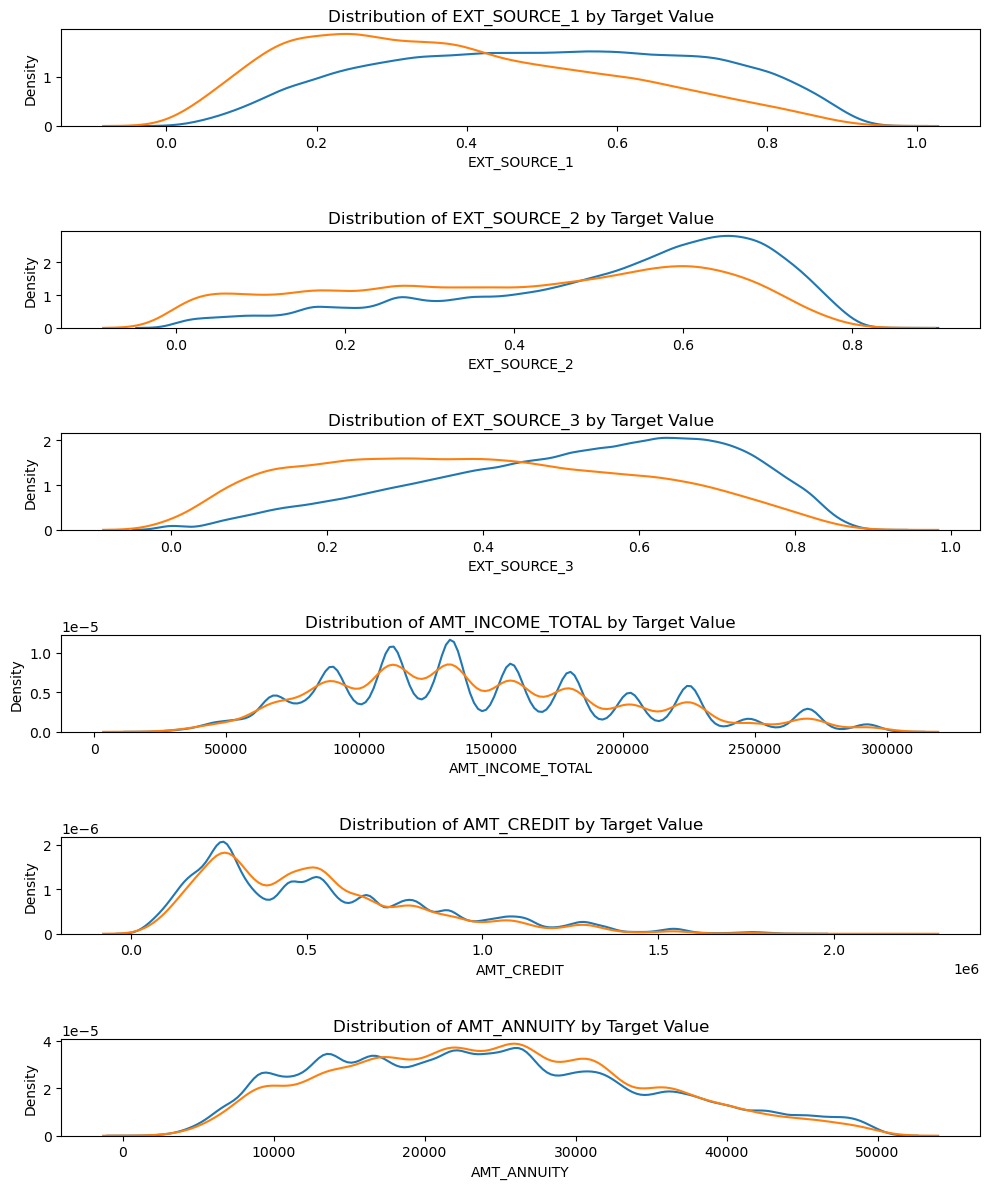

In [55]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']):
    
    # create a new subplot for each source
    plt.subplot(6, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_app_train3.loc[df_app_train2['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_app_train3.loc[df_app_train2['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 3)

## Corrélation des données 

In [56]:
df_app_train3.dropna(inplace=True)
df_app_train3

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.000,406597.5,24700.5,0,-9461,0,-637.000000,0,1,0.083037,0.262949,0.139376
6,0,100009,171000.000,1560726.0,41301.0,1,-13778,1,-3130.000000,1,1,0.774761,0.724000,0.492060
8,0,100011,112500.000,1019610.0,33826.5,0,-20099,1,-2356.487525,0,1,0.587334,0.205747,0.751724
10,0,100014,112500.000,652500.0,21177.0,1,-10197,1,-679.000000,0,1,0.319760,0.651862,0.363945
11,0,100015,38419.155,148365.0,10678.5,0,-20417,1,-2356.487525,0,1,0.722044,0.555183,0.652897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307499,0,456243,81000.000,225000.0,12694.5,0,-16988,1,-8694.000000,0,1,0.665343,0.649123,0.206779
307500,0,456244,261000.000,1303812.0,35982.0,0,-20390,1,-5326.000000,0,1,0.896042,0.789389,0.337673
307503,0,456247,112500.000,345510.0,17770.5,0,-11870,0,-399.000000,0,1,0.243466,0.501221,0.609276
307508,0,456253,153000.000,677664.0,29979.0,0,-14966,0,-7921.000000,0,1,0.744026,0.535722,0.218859


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

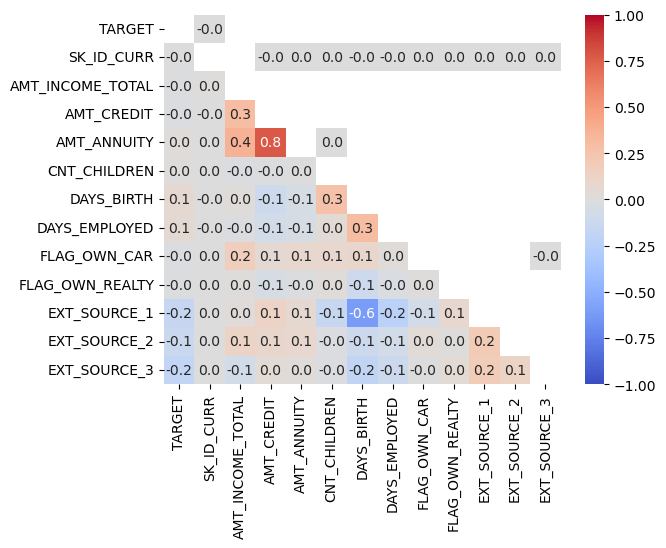

In [57]:
corr = df_app_train3.corr().round(2)
mask = np.triu(corr)

sns.heatmap(data =corr,annot=True,vmin=-1,vmax=1,cmap='coolwarm',fmt='.1f',mask = mask)

In [58]:
df_app_train3.isna().mean()

TARGET                0.0
SK_ID_CURR            0.0
AMT_INCOME_TOTAL      0.0
AMT_CREDIT            0.0
AMT_ANNUITY           0.0
CNT_CHILDREN          0.0
DAYS_BIRTH            0.0
NAME_FAMILY_STATUS    0.0
DAYS_EMPLOYED         0.0
FLAG_OWN_CAR          0.0
FLAG_OWN_REALTY       0.0
EXT_SOURCE_1          0.0
EXT_SOURCE_2          0.0
EXT_SOURCE_3          0.0
dtype: float64


## Modélisation des données 

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

X = df_app_train3.iloc[:,1:]

y = df_app_train3.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf = LogisticRegression(random_state=0)

clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [60]:
y_pred = clf.predict(X_test)

In [61]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28600
           1       0.00      0.00      0.00      2320

    accuracy                           0.92     30920
   macro avg       0.46      0.50      0.48     30920
weighted avg       0.86      0.92      0.89     30920



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [62]:
x_test = X_test.iloc[:,1:]
x_test

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
239118,126000.0,675000.0,19867.5,0,-20823,1,-3027.000000,0,1,0.792057,0.645348,0.698668
222098,157500.0,180000.0,11632.5,0,-8889,1,-1672.000000,1,0,0.148496,0.585381,0.292588
139002,225000.0,568800.0,15003.0,1,-10817,1,-700.000000,0,0,0.154554,0.231861,0.221335
93145,135000.0,104256.0,10813.5,0,-21644,0,-1388.000000,0,1,0.476196,0.409420,0.355639
289465,135000.0,450000.0,27193.5,0,-10418,1,-462.000000,0,1,0.066407,0.288975,0.190706
...,...,...,...,...,...,...,...,...,...,...,...,...
198149,270000.0,450000.0,22500.0,2,-12554,1,-2989.000000,1,1,0.425981,0.690842,0.436506
18906,270000.0,942300.0,24984.0,0,-22234,1,-12716.000000,1,0,0.526920,0.746404,0.735221
98135,112500.0,495000.0,24750.0,0,-22502,1,-2356.487525,0,1,0.803268,0.644432,0.755740
94261,90000.0,536917.5,22702.5,2,-13271,1,-3662.000000,0,1,0.312476,0.165968,0.247191


In [63]:
roc_auc_score(y_test,clf.predict_proba(X_test)[:,1] )

0.5959834368217989

In [64]:
roc_auc_score(y_test,clf.predict_proba(X_test)[:,0] )

0.4040165631782011

In [65]:
clf.classes_

array([0, 1], dtype=int64)

In [66]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

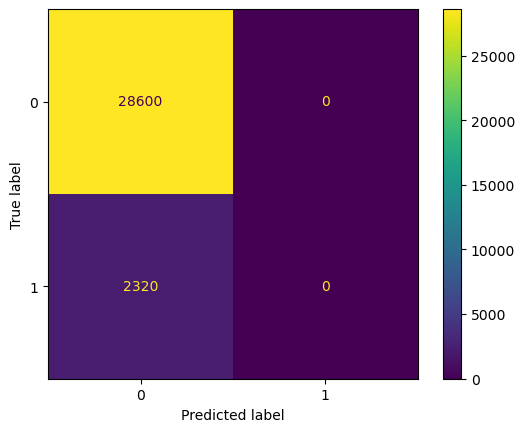

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [68]:
def roc_curve__confusion_matrix(model,classe):
    from sklearn.metrics import roc_curve, auc
    y_prob_test = model.predict_proba(X_test)[:, classe]
    y_prob_train  = model.predict_proba(X_train)[:, classe]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

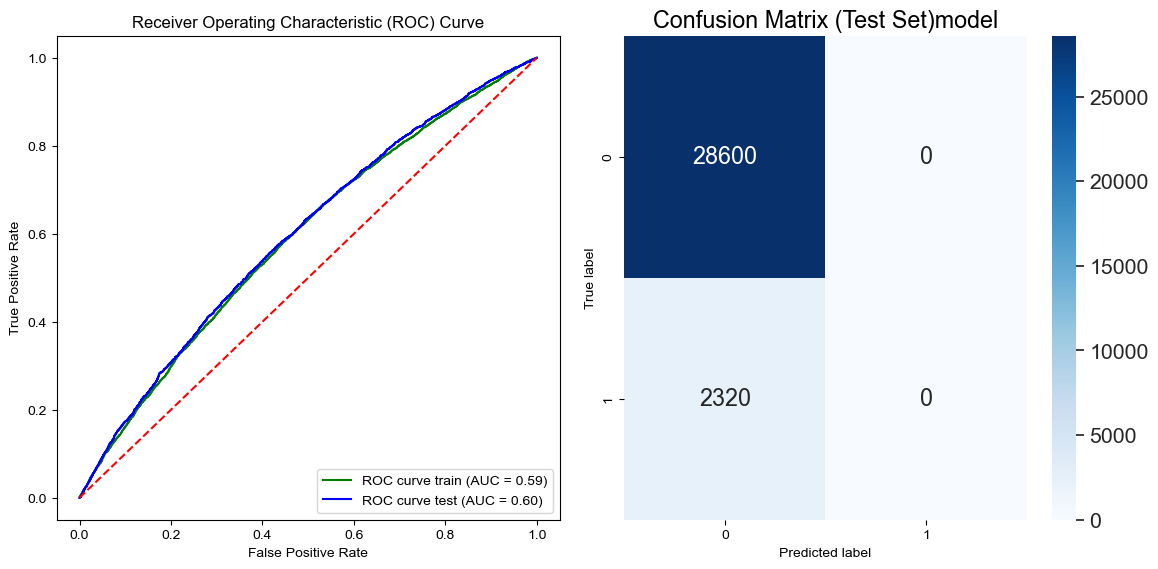

In [69]:
roc_curve__confusion_matrix(clf,1)

In [70]:
from sklearn.dummy import DummyClassifier


X = df_app_train3.iloc[:,1:]

y = df_app_train3.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

clf = DummyClassifier(random_state=0).fit(X_train, y_train)

In [71]:
y_pred = clf.predict(X_test)

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28600
           1       0.00      0.00      0.00      2320

    accuracy                           0.92     30920
   macro avg       0.46      0.50      0.48     30920
weighted avg       0.86      0.92      0.89     30920



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [73]:
df_app_train3.iloc[:,2:]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,202500.000,406597.5,24700.5,0,-9461,0,-637.000000,0,1,0.083037,0.262949,0.139376
6,171000.000,1560726.0,41301.0,1,-13778,1,-3130.000000,1,1,0.774761,0.724000,0.492060
8,112500.000,1019610.0,33826.5,0,-20099,1,-2356.487525,0,1,0.587334,0.205747,0.751724
10,112500.000,652500.0,21177.0,1,-10197,1,-679.000000,0,1,0.319760,0.651862,0.363945
11,38419.155,148365.0,10678.5,0,-20417,1,-2356.487525,0,1,0.722044,0.555183,0.652897
...,...,...,...,...,...,...,...,...,...,...,...,...
307499,81000.000,225000.0,12694.5,0,-16988,1,-8694.000000,0,1,0.665343,0.649123,0.206779
307500,261000.000,1303812.0,35982.0,0,-20390,1,-5326.000000,0,1,0.896042,0.789389,0.337673
307503,112500.000,345510.0,17770.5,0,-11870,0,-399.000000,0,1,0.243466,0.501221,0.609276
307508,153000.000,677664.0,29979.0,0,-14966,0,-7921.000000,0,1,0.744026,0.535722,0.218859


In [74]:
X = df_app_train3.iloc[:,2:]
y = df_app_train3.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

clf = RandomForestClassifier(random_state=0)

In [75]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [76]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28600
           1       0.48      0.01      0.03      2320

    accuracy                           0.92     30920
   macro avg       0.70      0.51      0.49     30920
weighted avg       0.89      0.92      0.89     30920



### Imbalenced classe

In [77]:
df_app_train3.iloc[:10,1].values

array([100002, 100009, 100011, 100014, 100015, 100016, 100019, 100025,
       100030, 100043], dtype=int64)

In [78]:
df_app_train3.isna().mean()

TARGET                0.0
SK_ID_CURR            0.0
AMT_INCOME_TOTAL      0.0
AMT_CREDIT            0.0
AMT_ANNUITY           0.0
CNT_CHILDREN          0.0
DAYS_BIRTH            0.0
NAME_FAMILY_STATUS    0.0
DAYS_EMPLOYED         0.0
FLAG_OWN_CAR          0.0
FLAG_OWN_REALTY       0.0
EXT_SOURCE_1          0.0
EXT_SOURCE_2          0.0
EXT_SOURCE_3          0.0
dtype: float64

In [79]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [80]:
model = Pipeline([
                  ('random_under_sampler',RandomUnderSampler(random_state=42)),
                  
                  ('random_forest', RandomForestClassifier(max_depth=2, random_state=0)),])
model

Pipeline(steps=[('random_under_sampler', RandomUnderSampler(random_state=42)),
                ('random_forest',
                 RandomForestClassifier(max_depth=2, random_state=0))])

In [81]:
df_app_train3

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.000,406597.5,24700.5,0,-9461,0,-637.000000,0,1,0.083037,0.262949,0.139376
6,0,100009,171000.000,1560726.0,41301.0,1,-13778,1,-3130.000000,1,1,0.774761,0.724000,0.492060
8,0,100011,112500.000,1019610.0,33826.5,0,-20099,1,-2356.487525,0,1,0.587334,0.205747,0.751724
10,0,100014,112500.000,652500.0,21177.0,1,-10197,1,-679.000000,0,1,0.319760,0.651862,0.363945
11,0,100015,38419.155,148365.0,10678.5,0,-20417,1,-2356.487525,0,1,0.722044,0.555183,0.652897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307499,0,456243,81000.000,225000.0,12694.5,0,-16988,1,-8694.000000,0,1,0.665343,0.649123,0.206779
307500,0,456244,261000.000,1303812.0,35982.0,0,-20390,1,-5326.000000,0,1,0.896042,0.789389,0.337673
307503,0,456247,112500.000,345510.0,17770.5,0,-11870,0,-399.000000,0,1,0.243466,0.501221,0.609276
307508,0,456253,153000.000,677664.0,29979.0,0,-14966,0,-7921.000000,0,1,0.744026,0.535722,0.218859


In [82]:
X = df_app_train3.iloc[:,2:]

y = df_app_train3.TARGET

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     11598
           1       0.15      0.64      0.24       958

    accuracy                           0.70     12556
   macro avg       0.55      0.67      0.53     12556
weighted avg       0.90      0.70      0.77     12556



In [83]:
model2 = Pipeline([
                  ('random_under_sampler',RandomUnderSampler(random_state=42)),
                  
                  ('random_forest', RandomForestClassifier(max_depth=2, random_state=0))])
model2

cols= ['TARGET',
        'SK_ID_CURR',
        'AMT_INCOME_TOTAL',
        'AMT_CREDIT',
        'AMT_ANNUITY',
        'CNT_CHILDREN',
        'DAYS_BIRTH',
        'DAYS_EMPLOYED',
        'EXT_SOURCE_1',
        'EXT_SOURCE_2',
        'EXT_SOURCE_3'] 

df_pickle =  df_app_train3.loc[:,cols]

X = df_pickle.iloc[:,2:]

y = df_pickle.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     17316
           1       0.15      0.65      0.24      1424

    accuracy                           0.68     18740
   macro avg       0.55      0.67      0.52     18740
weighted avg       0.90      0.68      0.76     18740



In [84]:
X = df_app_train3.iloc[:,2:]

y = df_app_train3.TARGET

rus = RandomUnderSampler()

X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

clf = LogisticRegression()

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1430
           1       0.67      0.67      0.67      1402

    accuracy                           0.67      2832
   macro avg       0.67      0.67      0.67      2832
weighted avg       0.67      0.67      0.67      2832



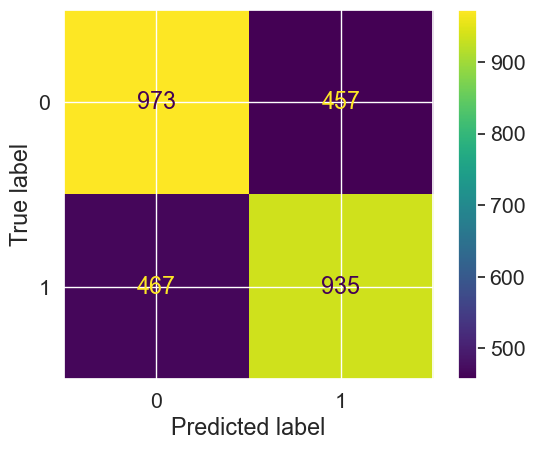

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [86]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7132545414642419

In [87]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 0])

0.2867454585357581

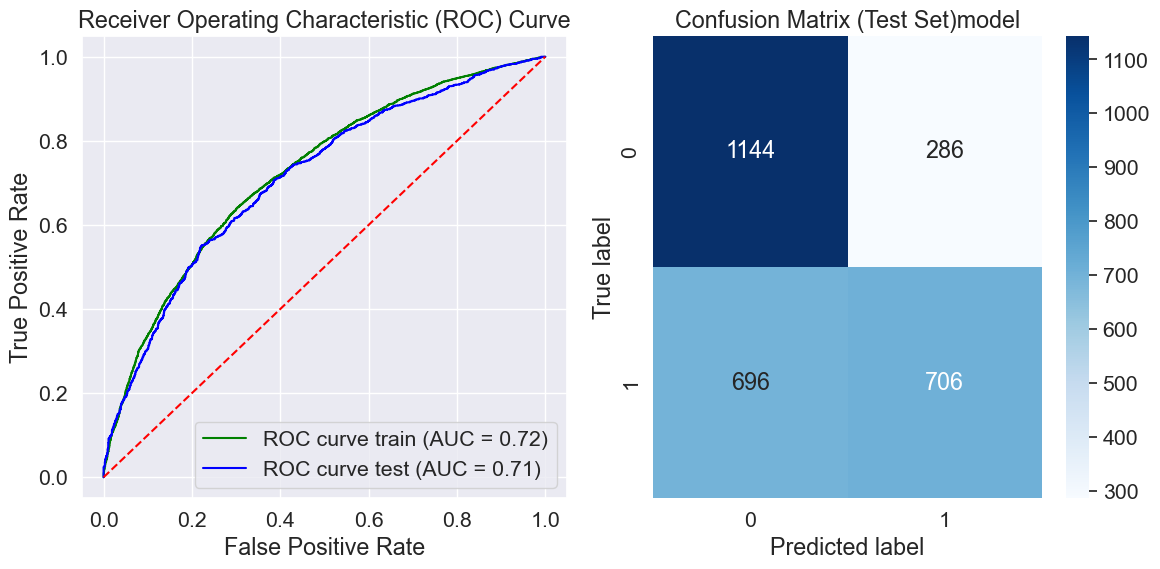

In [88]:
roc_curve__confusion_matrix(model,1)

In [89]:
df_sample = pd.DataFrame(df_app_train3.loc[y_test.index])
df_sample

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
264035,0,405749,112500.0,337500.0,16875.0,0,-19999,1,-3204.0,0,1,0.673643,0.671623,0.540654
119605,0,238696,202500.0,694773.0,29565.0,0,-22026,0,-3600.0,0,1,0.826330,0.542247,0.173527
18195,0,121223,247500.0,657702.0,21343.5,0,-17092,1,-2944.0,0,1,0.673464,0.759958,0.431192
247103,1,385945,270000.0,363190.5,24399.0,0,-18715,1,-356.0,0,1,0.561254,0.703171,0.406617
104195,1,220933,112500.0,135000.0,6750.0,1,-8339,1,-1061.0,1,1,0.332187,0.686853,0.071533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187151,1,316960,270000.0,1339884.0,39307.5,1,-14264,1,-758.0,1,1,0.742490,0.541004,0.109626
287256,0,432742,112500.0,490536.0,22995.0,1,-13827,1,-5123.0,0,1,0.251066,0.141325,0.560284
218067,0,352645,112500.0,270000.0,13500.0,1,-10346,1,-231.0,0,1,0.517348,0.663529,0.486653
232616,1,369429,238500.0,512064.0,25033.5,0,-11084,0,-331.0,0,1,0.441657,0.369198,0.083364


In [90]:
df_sample['y_pred'] = y_pred
df_sample['proba'] = model.predict_proba(X_test)[:,0]
df_sample['gain'] = 0
df_sample['perte'] = 0
df_sample

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,y_pred,proba,gain,perte
264035,0,405749,112500.0,337500.0,16875.0,0,-19999,1,-3204.0,0,1,0.673643,0.671623,0.540654,0,0.641881,0,0
119605,0,238696,202500.0,694773.0,29565.0,0,-22026,0,-3600.0,0,1,0.826330,0.542247,0.173527,1,0.520522,0,0
18195,0,121223,247500.0,657702.0,21343.5,0,-17092,1,-2944.0,0,1,0.673464,0.759958,0.431192,0,0.636604,0,0
247103,1,385945,270000.0,363190.5,24399.0,0,-18715,1,-356.0,0,1,0.561254,0.703171,0.406617,0,0.611553,0,0
104195,1,220933,112500.0,135000.0,6750.0,1,-8339,1,-1061.0,1,1,0.332187,0.686853,0.071533,1,0.447906,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187151,1,316960,270000.0,1339884.0,39307.5,1,-14264,1,-758.0,1,1,0.742490,0.541004,0.109626,0,0.493444,0,0
287256,0,432742,112500.0,490536.0,22995.0,1,-13827,1,-5123.0,0,1,0.251066,0.141325,0.560284,1,0.466219,0,0
218067,0,352645,112500.0,270000.0,13500.0,1,-10346,1,-231.0,0,1,0.517348,0.663529,0.486653,0,0.614929,0,0
232616,1,369429,238500.0,512064.0,25033.5,0,-11084,0,-331.0,0,1,0.441657,0.369198,0.083364,1,0.388888,0,0


In [91]:
len(y_test),len(y_pred)

(2832, 2832)

In [92]:
def perte(dataframe, y_true, y_pred,col_credit, rate_default:float):
    
    df = {'Index':y_true.index,'y_pred':y_pred,'Target':y_true.values}
    df_pred = pd.DataFrame(df)
    idx = df_pred.loc[(df_pred.y_pred == 1) & (df_pred.Target == 0),'Index'] 
    dataframe['perte'] = -dataframe.loc[idx,col_credit] * rate_default
    return dataframe

def gain(df, y_proba, threshold:float, rate_interest:float):
        
        
        df['proba'] = y_proba
        df['gain'] = 0
        df['y_pred'] = np.nan
        
        df['gain'] = df.loc[(df.proba >= threshold), 'AMT_CREDIT'] * rate_interest
        df.loc[(df.proba >= threshold), 'y_pred'] = 0
        df.loc[(df.proba < threshold), 'y_pred'] = 1
            
                
        return df['gain'], y_pred
    


In [93]:
th = np.linspace(0.5,0.6,30)
th

array([0.5       , 0.50344828, 0.50689655, 0.51034483, 0.5137931 ,
       0.51724138, 0.52068966, 0.52413793, 0.52758621, 0.53103448,
       0.53448276, 0.53793103, 0.54137931, 0.54482759, 0.54827586,
       0.55172414, 0.55517241, 0.55862069, 0.56206897, 0.56551724,
       0.56896552, 0.57241379, 0.57586207, 0.57931034, 0.58275862,
       0.5862069 , 0.58965517, 0.59310345, 0.59655172, 0.6       ])

In [94]:
df_sample = perte(df_sample, y_test, y_pred,'AMT_CREDIT', 0.5)
df_sample.perte.agg('sum')

-120874009.5

In [95]:
result_gain = []
for threshold in th:
    df_sample['gain'], df_sample['y_pred2'] = gain(df_sample,df_sample.proba,threshold, 0.04)
    result_gain.append(df_sample.gain.agg(('sum')))
df_sample

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,y_pred,proba,gain,perte,y_pred2
264035,0,405749,112500.0,337500.0,16875.0,0,-19999,1,-3204.0,0,1,0.673643,0.671623,0.540654,0.0,0.641881,13500.00,NaN,0
119605,0,238696,202500.0,694773.0,29565.0,0,-22026,0,-3600.0,0,1,0.826330,0.542247,0.173527,1.0,0.520522,NaN,-347386.5,1
18195,0,121223,247500.0,657702.0,21343.5,0,-17092,1,-2944.0,0,1,0.673464,0.759958,0.431192,0.0,0.636604,26308.08,NaN,0
247103,1,385945,270000.0,363190.5,24399.0,0,-18715,1,-356.0,0,1,0.561254,0.703171,0.406617,0.0,0.611553,14527.62,NaN,0
104195,1,220933,112500.0,135000.0,6750.0,1,-8339,1,-1061.0,1,1,0.332187,0.686853,0.071533,1.0,0.447906,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187151,1,316960,270000.0,1339884.0,39307.5,1,-14264,1,-758.0,1,1,0.742490,0.541004,0.109626,1.0,0.493444,NaN,NaN,0
287256,0,432742,112500.0,490536.0,22995.0,1,-13827,1,-5123.0,0,1,0.251066,0.141325,0.560284,1.0,0.466219,NaN,-245268.0,1
218067,0,352645,112500.0,270000.0,13500.0,1,-10346,1,-231.0,0,1,0.517348,0.663529,0.486653,0.0,0.614929,10800.00,NaN,0
232616,1,369429,238500.0,512064.0,25033.5,0,-11084,0,-331.0,0,1,0.441657,0.369198,0.083364,1.0,0.388888,NaN,NaN,1


<Axes: >

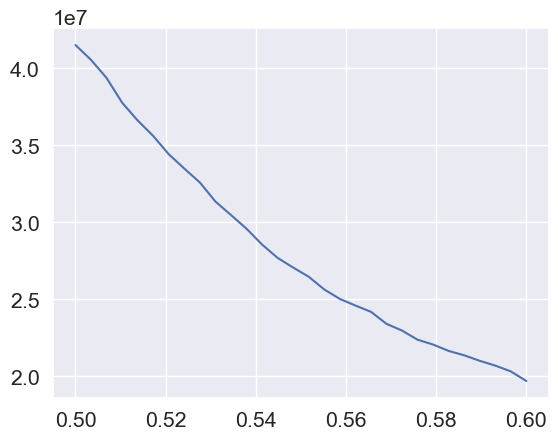

In [96]:
sns.lineplot(x = th , y = result_gain)

In [97]:
df_app_test2 = df_app_test
df_app_test2 = encodage_variable('NAME_FAMILY_STATUS',df_app_test2)
df_app_test2 = encodage_variable('FLAG_OWN_CAR',df_app_test2)
df_app_test2 = encodage_variable('FLAG_OWN_REALTY',df_app_test2)


In [98]:

df_app_test2.dtypes

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                    int32
FLAG_OWN_REALTY                 int32
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

In [99]:
cols =['SK_ID_CURR',
     'AMT_INCOME_TOTAL',
     'AMT_CREDIT',
     'AMT_ANNUITY',
     'CNT_CHILDREN',
     'DAYS_BIRTH',
     'NAME_FAMILY_STATUS',
     'DAYS_EMPLOYED',
     'FLAG_OWN_CAR',
     'FLAG_OWN_REALTY',
     'EXT_SOURCE_1',
     'EXT_SOURCE_2',
     'EXT_SOURCE_3']

In [100]:
df_app_test2 = df_app_test.loc[:, cols]
df_app_test2.dropna(inplace=True)
df_app_test2

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,135000.0,568800.0,20560.5,0,-19241,1,-2329,0,1,0.752614,0.789654,0.159520
1,100005,99000.0,222768.0,17370.0,0,-18064,1,-4469,0,1,0.564990,0.291656,0.432962
3,100028,315000.0,1575000.0,49018.5,2,-13976,1,-1866,0,1,0.525734,0.509677,0.612704
6,100057,180000.0,499221.0,22117.5,2,-16685,1,-2580,1,1,0.760851,0.571084,0.651260
7,100065,166500.0,180000.0,14220.0,0,-9516,3,-1387,0,1,0.565290,0.613033,0.312365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48736,456170,157500.0,500490.0,48888.0,0,-21780,3,365243,1,1,0.851722,0.471719,0.631355
48737,456189,270000.0,360000.0,28570.5,0,-19397,2,-119,0,1,0.442558,0.689832,0.255332
48738,456202,135000.0,252022.5,23112.0,3,-11708,0,-369,1,0,0.174671,0.762352,0.240541
48741,456223,202500.0,315000.0,33205.5,1,-15922,1,-3037,1,1,0.733503,0.632770,0.283712


In [101]:
y_p = model.predict_proba(df_app_test2.iloc[:,1:])
y_p

X has feature names, but RandomForestClassifier was fitted without feature names


array([[0.63694534, 0.36305466],
       [0.63547547, 0.36452453],
       [0.63547547, 0.36452453],
       ...,
       [0.63994148, 0.36005852],
       [0.63701685, 0.36298315],
       [0.63547547, 0.36452453]])

In [102]:
y_p = pd.DataFrame(y_p)
y_p.loc[y_p.iloc[:,0] != 0]

,0,1
0,0.636945,0.363055
1,0.635475,0.364525
2,0.635475,0.364525
3,0.637017,0.362983
4,0.635475,0.364525
...,...,...
23565,0.617052,0.382948
23566,0.635475,0.364525
23567,0.639941,0.360059
23568,0.637017,0.362983


In [107]:
y_p = pd.Series(y_p.iloc[:,0])
y_p[y_p == 0]

Series([], Name: 0, dtype: float64)

# Code Kaggle

In [65]:
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [66]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [67]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [68]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('source/application_train.csv',sep=',',nrows= num_rows)
    test_df = pd.read_csv('source/application_test.csv',sep=',',nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [69]:

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('source/bureau.csv',sep=',', nrows = num_rows)
    bb = pd.read_csv('source/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [70]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('source/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [71]:

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('source/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [72]:
   
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('source/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [73]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('source/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [74]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    train_df.fillna(0,inplace = True)
    train_df.columns = [e.upper() for e in train_df.columns.tolist()]

    test_df = df[df['TARGET'].isnull()]
    test_df.fillna(0,inplace = True)
    test_df.columns = [e.upper() for e in test_df.columns.tolist()]

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','INDEX']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', callbacks=[early_stopping(stopping_rounds=3)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
        display_importances(feature_importance_df)
        return feature_importance_df

In [75]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [76]:
import re

def remove_special_characters(text):
    # enlever les caractères spéciaux
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'[^\w]', '', cleaned_text )
    return cleaned_text

In [77]:
df_importance = pd.DataFrame()
df_importance

""


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116) df of shape (356251, 364)
Process bureau and bureau_balance - done in 25s
Previous applications df shape: (338857, 249) df of shape (356251, 613)
Process previous_applications - done in 30s
Pos-cash balance df shape: (337252, 18) df of shape (356251, 631)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26) df of shape (356251, 657)
Process installments payments - done in 34s
Credit card balance df shape: (103558, 141) df of shape (356251, 798)
Process credit card balance - done in 192s



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[534]	training's auc: 0.848826	training's binary_logloss: 0.214597	valid_1's auc: 0.784858	valid_1's binary_logloss: 0.238244
Fold  1 AUC : 0.784858
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[499]	training's auc: 0.847297	training's binary_logloss: 0.215741	valid_1's auc: 0.782872	valid_1's binary_logloss: 0.238483
Fold  2 AUC : 0.782872
Full AUC score 0.783855



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Run LightGBM with kfold - done in 195s
Full model run - done in 498s


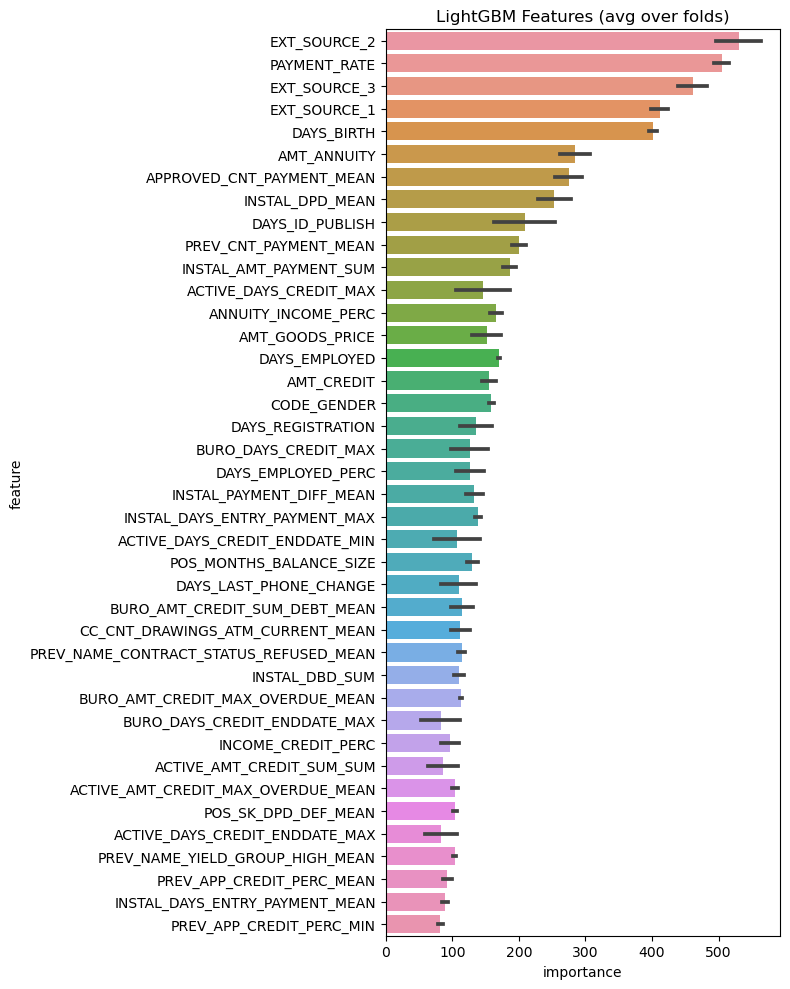

In [78]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print("Bureau df shape:", bureau.shape, 'df of shape', df.shape)
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("Previous applications df shape:", prev.shape, 'df of shape', df.shape)
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("Pos-cash balance df shape:", pos.shape, 'df of shape', df.shape)
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("Installments payments df shape:", ins.shape, 'df of shape', df.shape)
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        df.to_csv('Preprocessing/kernel.csv', index = False)
        print("Credit card balance df shape:", cc.shape, 'df of shape', df.shape)
        del cc
        gc.collect()
        df.columns = [remove_special_characters(i) for i in df.columns]
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 2, stratified= False, debug= debug)
        
    return feat_importance, df

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_importance, df = main()

In [79]:
feats = [f for f in df.columns if f not in ['SK_ID_BUREAU','SK_ID_PREV','index']]
cols = df_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
df_importance

,feature,importance,fold
0,CODE_GENDER,155,1
1,FLAG_OWN_CAR,88,1
2,FLAG_OWN_REALTY,2,1
3,CNT_CHILDREN,0,1
4,AMT_INCOME_TOTAL,24,1
...,...,...,...
790,CC_NAME_CONTRACT_STATUS_NAN_MAX,0,2
791,CC_NAME_CONTRACT_STATUS_NAN_MEAN,0,2
792,CC_NAME_CONTRACT_STATUS_NAN_SUM,0,2
793,CC_NAME_CONTRACT_STATUS_NAN_VAR,0,2


In [80]:
df.loc[:,cols]

feature,EXT_SOURCE_2,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,AMT_ANNUITY,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,DAYS_ID_PUBLISH,PREV_CNT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,DAYS_EMPLOYED,ANNUITY_INCOME_PERC,CODE_GENDER,AMT_CREDIT
0,0.262949,0.060749,0.139376,0.083037,-9461,24700.5,24.000000,0.000000,-2120,24.000000,219625.695,-637.0,0.121978,0,406597.5
1,0.622246,0.027598,NaN,0.311267,-16765,35698.5,10.000000,0.000000,-291,10.000000,1618864.650,-1188.0,0.132217,1,1293502.5
2,0.555912,0.050000,0.729567,NaN,-19046,6750.0,4.000000,0.000000,-2531,4.000000,21288.465,-225.0,0.100000,0,135000.0
3,0.650442,0.094941,NaN,NaN,-19005,29686.5,18.000000,0.000000,-2437,23.000000,1007153.415,-3039.0,0.219900,1,312682.5
4,0.322738,0.042623,NaN,NaN,-19932,21865.5,20.666667,0.954545,-3458,20.666667,806127.975,-3038.0,0.179963,0,513000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,0.648575,0.042354,0.643026,NaN,-19970,17473.5,24.000000,0.000000,-3399,24.000000,273109.365,-5169.0,0.143815,1,412560.0
356251,0.684596,0.051267,NaN,NaN,-11186,31909.5,17.500000,0.520548,-3003,17.500000,567315.675,-1149.0,0.202600,1,622413.0
356252,0.632770,0.105414,0.283712,0.733503,-15922,33205.5,11.000000,0.000000,-1504,11.000000,185271.930,-3037.0,0.163978,1,315000.0
356253,0.445701,0.055840,0.595456,0.373090,-13968,25128.0,17.000000,0.034483,-1364,14.500000,500807.790,-2731.0,0.111680,0,450000.0


## Calcul des pertes

In [82]:
def model_lgbm(df,col):

    model = Pipeline([
                      ('random_under_sampler',RandomUnderSampler(random_state=42)),
                      ('scaler', StandardScaler()),
                      ('random_forest', LGBMClassifier(
                                                        nthread=4,
                                                        n_estimators=10000,
                                                        learning_rate=0.02,
                                                        num_leaves=34,
                                                        colsample_bytree=0.9497036,
                                                        subsample=0.8715623,
                                                        max_depth=8,
                                                        reg_alpha=0.041545473,
                                                        reg_lambda=0.0735294,
                                                        min_split_gain=0.0222415,
                                                        min_child_weight=39.3259775,
                                                        silent=-1,
                                                        verbose=-1, )),])
    
    
    
    df.fillna(0, inplace = True)
    
    X = df.loc[:,col]
    
    y = df.TARGET
    
    

    '''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    X = df_app_train3.iloc[:,2:]

    y = df_app_train3.TARGET'''

    rus = RandomUnderSampler()

    X_res, y_res = rus.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

    clf = LGBMClassifier(
                                                        nthread=4,
                                                        n_estimators=10000,
                                                        learning_rate=0.02,
                                                        num_leaves=34,
                                                        colsample_bytree=0.9497036,
                                                        subsample=0.8715623,
                                                        max_depth=8,
                                                        reg_alpha=0.041545473,
                                                        reg_lambda=0.0735294,
                                                        min_split_gain=0.0222415,
                                                        min_child_weight=39.3259775,
                                                        silent=-1,
                                                        verbose=-1)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    y_proba = clf.predict_proba(X_test)

    print(classification_report(y_test,y_pred))
    
    return y_test, y_pred,  y_proba



In [333]:
def perte(dataframe, y_true, y_pred,col_credit, rate_default:float):
    
    df = {'Index':y_true.index,'y_pred':y_pred,'Target':y_true.values}
    df_pred = pd.DataFrame(df)
    idx = df_pred.loc[(df_pred.y_pred == 1) & (df_pred.Target == 0),'Index'] 
    dataframe['perte'] = -dataframe.loc[idx,col_credit] * rate_default
    return dataframe

def gain(df, y_proba, threshold:float, rate_interest:float):
        
        
        df['proba'] = y_proba[:,0]
        df['gain'] = 0
        df['y_pred'] = np.nan
        
        df['gain'] = df.loc[(df.proba >= threshold), 'AMT_CREDIT'] * rate_interest
        df.loc[(df.proba >= threshold), 'y_pred'] = 0
        df.loc[(df.proba < threshold), 'y_pred'] = 1
            
                
        return df['gain'], y_pred
    


In [85]:
y_test, y_pred, y_proba = model_lgbm(df,cols)

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      4953
         1.0       0.68      0.68      0.68      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



In [127]:
cols

Index(['EXT_SOURCE_2', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1', 'AMT_ANNUITY', 'APPROVED_CNT_PAYMENT_MEAN',
       'INSTAL_DPD_MEAN', 'DAYS_ID_PUBLISH', 'PREV_CNT_PAYMENT_MEAN',
       'INSTAL_AMT_PAYMENT_SUM', 'ANNUITY_INCOME_PERC', 'DAYS_EMPLOYED',
       'AMT_CREDIT', 'AMT_GOODS_PRICE'],
      dtype='object', name='feature')

In [128]:
df_sample = pd.DataFrame(df.loc[y_test.index])
df_sample

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
45071,45071,152211,0.0,1,0,0,0,135000.0,972000.0,28417.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,23.0
213045,213045,346883,0.0,1,1,0,2,94500.0,1006920.0,51543.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
270580,270580,413623,0.0,1,1,1,0,67500.0,545040.0,20677.5,...,1.0,0.166667,1.0,0.166667,0.0,0.0,0.0,0.0,0.0,6.0
147640,147640,271185,0.0,0,1,0,0,126000.0,835605.0,24561.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
181810,181810,310732,0.0,1,1,0,2,216000.0,1354500.0,53716.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109127,109127,226571,0.0,0,0,0,0,157500.0,439074.0,22549.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,13.0
176783,176783,304859,1.0,1,0,1,0,90000.0,490495.5,27517.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
293956,293956,440560,0.0,1,0,1,2,202500.0,1256400.0,33273.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
352185,44674,427074,0.0,0,0,0,0,135000.0,720000.0,25992.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:


df_sample = perte(df_sample, y_test,y_pred, 'AMT_CREDIT', 0.5)

df_sample.perte.agg('sum')

-437014876.5

In [130]:
df_sample['gain'], y_p = gain(df_sample,y_proba, 0.6, 0.04)
df_sample.gain.agg('sum')


100612519.02

# Shap values


In [83]:
len(feats)

797

In [85]:
df.loc[:,feats]

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df2 = df.loc[:,feats]
df2

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
shap.initjs()

In [135]:
def drop_row(df:object,threhold:float):
    
    mask = df.isna().mean() < 0.7
    df = df.loc[:,mask[mask == True].index]
    df.dropna(inplace = True)
    return df

In [130]:
df2 = df2.loc[df2.loc[df2.TARGET.isna() == False,'TARGET'].index]


In [123]:
df2.TARGET

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
356250    NaN
356251    NaN
356252    NaN
356253    NaN
356254    NaN
Name: TARGET, Length: 356251, dtype: float64

In [131]:
X = df2.iloc[:,2:]

X = X.replace([np.inf, -np.inf], np.nan)

y = df2.TARGET


In [338]:
from sklearn.impute import KNNImputer


rus = RandomUnderSampler()

X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

clf = LGBMClassifier(nthread=4,
                     n_estimators=10000,
                     learning_rate=0.02,
                     num_leaves=34,
                     colsample_bytree=0.9497036,
                     subsample=0.8715623,
                     max_depth=8,
                     reg_alpha=0.041545473,
                     reg_lambda=0.0735294,
                     min_split_gain=0.0222415,
                     min_child_weight=39.3259775,
                     silent=-1,
                     verbose=-1)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

model_lgbm = clf.fit(X_train, y_train)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_lgbm, X_train, check_additivity=False)


# visualize the first prediction's explanation


In [339]:
shap_values = explainer(X_train[:3000],check_additivity=False)

100%|===================| 2998/3000 [29:14<00:01]        

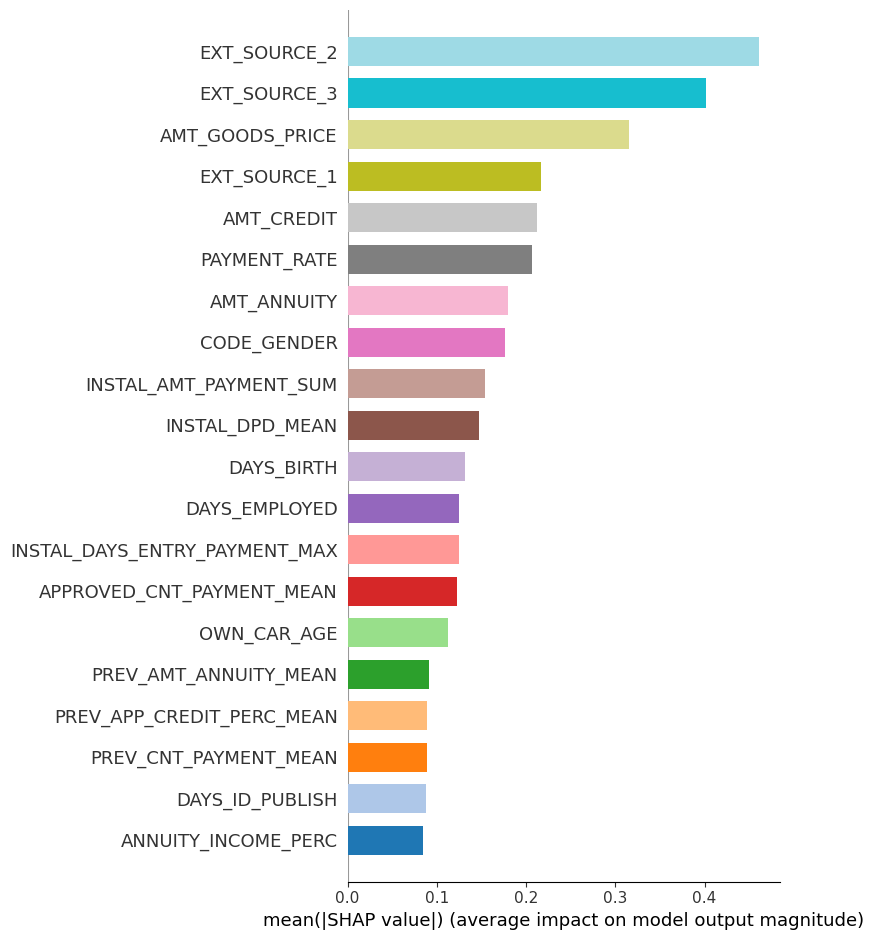

In [340]:
n_colors = 30
color_palette = sns.color_palette("tab20", n_colors=n_colors)
shap.summary_plot(shap_values,feature_names=df2.iloc[:,2:].columns, plot_type='bar', color=color_palette,)

In [341]:
df2.iloc[:,2:].shape

(307507, 795)

In [342]:
len(shap_values.values.mean(axis = 0))

795

In [347]:
mean_abs_shap_values = shap_values.values.mean(axis = 0)

# Trier les variables par ordre d'importance décroissante
sorted_indices = np.argsort(mean_abs_shap_values)

# Obtenir les noms des variables
feature_names = df2.iloc[:,2:].columns

# Obtenir les noms des variables les plus importantes
top_feature_names = [feature_names[idx] for idx in sorted_indices]

print("Variables les plus importantes :", top_feature_names[:15])

Variables les plus importantes : ['EXT_SOURCE_2', 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'EXT_SOURCE_1', 'NAME_EDUCATION_TYPE_Highereducation', 'ACTIVE_AMT_CREDIT_SUM_MAX', 'INSTAL_AMT_INSTALMENT_MAX', 'ORGANIZATION_TYPE_Selfemployed', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'INCOME_CREDIT_PERC', 'EXT_SOURCE_3', 'PREV_APP_CREDIT_PERC_MIN', 'PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN', 'PREV_NAME_YIELD_GROUP_high_MEAN', 'POS_SK_DPD_DEF_MAX', 'BURO_STATUS_1_MEAN_MEAN']


In [350]:
y_test, y_pred, y_proba = model_lgbm(df2,top_feature_names[:15])

              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66      4953
         1.0       0.66      0.68      0.67      4977

    accuracy                           0.67      9930
   macro avg       0.67      0.67      0.67      9930
weighted avg       0.67      0.67      0.67      9930



In [1]:
df_sample = pd.DataFrame(df2.loc[y_test.index])

df_sample = perte(df_sample, y_test,y_pred, 'AMT_CREDIT', 0.5)

df_sample.perte.agg('sum')

NameError: name 'pd' is not defined

In [ ]:

df_sample['gain'], y_p = gain(df_sample,y_proba, 0.6, 0.04)
df_sample.gain.agg('sum')

# df bureau

In [ ]:
df_bureau

In [2]:
df_bureau.isna().mean()

NameError: name 'df_bureau' is not defined

In [3]:
for col in df_bureau.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)

NameError: name 'df_bureau' is not defined

In [4]:
df_bureau_train = df_app_train3.merge(df_bureau, how='left', on='SK_ID_CURR')
df_bureau_train

NameError: name 'df_app_train3' is not defined

In [59]:
df_bureau_train.iloc[:,:15]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SK_ID_BUREAU
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,1,0.083037,0.262949,0.139376,6158904.0
1,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,1,0.083037,0.262949,0.139376,6158905.0
2,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,1,0.083037,0.262949,0.139376,6158906.0
3,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,1,0.083037,0.262949,0.139376,6158907.0
4,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,1,0.083037,0.262949,0.139376,6158908.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556861,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,0,0.734460,0.708569,0.113922,5126333.0
556862,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,0,0.734460,0.708569,0.113922,5126334.0
556863,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,0,0.734460,0.708569,0.113922,5126335.0
556864,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,0,0.734460,0.708569,0.113922,5126336.0


In [60]:
df_bureau_train.iloc[:,15:27]

,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0
1,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.00,NaN,0.0
2,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.00,0.0,0.0
3,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0
4,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
556861,Active,currency 1,-363.0,0.0,1463.0,NaN,0.000,0.0,436032.0,363573.54,0.0,0.0
556862,Active,currency 1,-451.0,0.0,279.0,NaN,15439.905,0.0,450000.0,191005.47,0.0,0.0
556863,Closed,currency 1,-1512.0,0.0,315.0,-781.0,25578.000,0.0,900000.0,NaN,NaN,0.0
556864,Closed,currency 1,-2337.0,0.0,8620.0,-779.0,2646.000,1.0,38925.0,NaN,NaN,0.0


In [61]:
df_bureau_train.loc[(df_bureau_train.CREDIT_ACTIVE == 'Active') &(df_bureau_train.AMT_CREDIT_MAX_OVERDUE >0)]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
5,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,NaN,40.500,0.0,31988.565,0.000,31988.565,0.0,Credit card,-24.0,0.000
36,0,100014,112500.0,652500.0,21177.0,1,-10197,1,-679.0,0,...,NaN,12752.280,0.0,571500.000,420201.000,0.000,0.0,Consumer credit,-25.0,NaN
62,0,100044,121500.0,454500.0,15151.5,0,-21077,1,-1288.0,0,...,NaN,18406.935,0.0,135000.000,-130.005,418630.005,0.0,Credit card,-651.0,NaN
63,0,100044,121500.0,454500.0,15151.5,0,-21077,1,-1288.0,0,...,NaN,1125.000,0.0,22500.000,-78.885,247578.885,0.0,Credit card,-654.0,NaN
64,0,100044,121500.0,454500.0,15151.5,0,-21077,1,-1288.0,0,...,NaN,14310.000,0.0,279859.500,261509.490,0.000,0.0,Consumer credit,-218.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556793,0,456234,81000.0,135000.0,9148.5,0,-9874,0,-1928.0,0,...,NaN,21294.000,0.0,787500.000,NaN,NaN,0.0,Consumer credit,-12.0,13125.015
556818,0,456244,261000.0,1303812.0,35982.0,0,-20390,1,-5326.0,0,...,NaN,10787.445,0.0,225000.000,-534.645,534.645,0.0,Credit card,-679.0,47457.000
556843,0,456247,112500.0,345510.0,17770.5,0,-11870,0,-399.0,0,...,NaN,22027.500,0.0,900000.000,0.000,0.000,0.0,Consumer credit,-32.0,4329.000
556847,0,456247,112500.0,345510.0,17770.5,0,-11870,0,-399.0,0,...,NaN,2898.000,0.0,94500.000,NaN,NaN,0.0,Credit card,-12.0,0.000


In [62]:
from sklearn.preprocessing import LabelEncoder

def encodage_variable(col, df):
    
    enc = LabelEncoder()
    
    X = df[col]

    X_enc = enc.fit_transform(X)

    X_enc

    df[col] = X_enc
    
    return df[col]

In [63]:
df_bureau.CREDIT_ACTIVE.unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [64]:
df_bureau_train['debt_days_previous_credit'] = df_bureau_train.DAYS_ENDDATE_FACT - df_bureau_train.DAYS_CREDIT_ENDDATE
df_bureau_train['statut_credit_bureau'] = encodage_variable('CREDIT_ACTIVE',df_bureau_train)

In [65]:
df_bureau_train

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,debt_days_previous_credit,statut_credit_bureau
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0,0.0,2
1,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,0.0,0.0,0.00,NaN,0.0,Credit card,-47.0,NaN,NaN,2
2,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,0.0,135000.0,0.00,0.0,0.0,Consumer credit,-1185.0,0.0,-113.0,2
3,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0,0.0,2
4,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.0,0,...,0.0,120735.0,0.00,0.0,0.0,Consumer credit,-34.0,0.0,-121.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556861,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,...,0.0,436032.0,363573.54,0.0,0.0,Consumer credit,-25.0,0.0,NaN,0
556862,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,...,0.0,450000.0,191005.47,0.0,0.0,Consumer credit,-55.0,3244.5,NaN,0
556863,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,...,0.0,900000.0,NaN,NaN,0.0,Consumer credit,-781.0,0.0,-1096.0,2
556864,0,456255,157500.0,675000.0,49117.5,0,-16856,1,-1262.0,0,...,1.0,38925.0,NaN,NaN,0.0,Credit card,-779.0,3244.5,-9399.0,2


In [66]:
df_bureau_train.columns
cols = ['TARGET', 'SK_ID_CURR', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'AMT_ANNUITY_x', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE','debt_days_previous_credit']

In [67]:
df_bureau_train.loc[:,cols]

,TARGET,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY_x,FLAG_OWN_CAR,FLAG_OWN_REALTY,SK_ID_BUREAU,CREDIT_ACTIVE,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,debt_days_previous_credit
0,1,100002,0,-9461,-637.0,24700.5,0,1,6158904.0,2,...,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,1,100002,0,-9461,-637.0,24700.5,0,1,6158905.0,2,...,-48.0,NaN,0.0,0.0,0.00,NaN,0.0,Credit card,-47.0,NaN
2,1,100002,0,-9461,-637.0,24700.5,0,1,6158906.0,2,...,-1185.0,0.000,0.0,135000.0,0.00,0.0,0.0,Consumer credit,-1185.0,-113.0
3,1,100002,0,-9461,-637.0,24700.5,0,1,6158907.0,2,...,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,1,100002,0,-9461,-637.0,24700.5,0,1,6158908.0,2,...,-36.0,5043.645,0.0,120735.0,0.00,0.0,0.0,Consumer credit,-34.0,-121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556861,0,456255,0,-16856,-1262.0,49117.5,0,0,5126333.0,0,...,NaN,0.000,0.0,436032.0,363573.54,0.0,0.0,Consumer credit,-25.0,NaN
556862,0,456255,0,-16856,-1262.0,49117.5,0,0,5126334.0,0,...,NaN,15439.905,0.0,450000.0,191005.47,0.0,0.0,Consumer credit,-55.0,NaN
556863,0,456255,0,-16856,-1262.0,49117.5,0,0,5126335.0,2,...,-781.0,25578.000,0.0,900000.0,NaN,NaN,0.0,Consumer credit,-781.0,-1096.0
556864,0,456255,0,-16856,-1262.0,49117.5,0,0,5126336.0,2,...,-779.0,2646.000,1.0,38925.0,NaN,NaN,0.0,Credit card,-779.0,-9399.0


In [68]:
df_bureau_train2 = df_bureau_train.loc[df_bureau_train.SK_ID_CURR.unique()]
df_bureau_train2.loc[df_bureau_train2.debt_days_previous_credit < 0]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,debt_days_previous_credit,statut_credit_bureau
100002,0,164182,45000.0,210456.0,9810.0,0,-15785,1,-1850.000000,0,...,0.0,135000.00,0.0,NaN,0.0,Consumer credit,-179.0,NaN,-141.0,2
100009,0,164186,112500.0,225000.0,8482.5,0,-17274,0,-1975.000000,0,...,0.0,202500.00,0.0,0.0,0.0,Consumer credit,-599.0,NaN,-51.0,2
100016,0,164187,114750.0,572076.0,39946.5,0,-12703,1,-5160.000000,0,...,0.0,1125000.00,0.0,0.0,0.0,Consumer credit,-444.0,NaN,-1011.0,2
100030,0,164190,90000.0,550980.0,43659.0,1,-13347,1,-2394.000000,1,...,0.0,360000.00,0.0,0.0,0.0,Consumer credit,-260.0,0.0,-120.0,2
100055,0,164217,180000.0,765000.0,44856.0,0,-13353,1,-1162.000000,0,...,0.0,103275.00,0.0,0.0,0.0,Consumer credit,-1097.0,NaN,-2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456176,0,391250,112500.0,454500.0,14661.0,0,-12840,0,-1930.000000,0,...,0.0,23008.50,0.0,0.0,0.0,Consumer credit,-1672.0,NaN,-91.0,2
456208,0,391282,234000.0,1125000.0,33025.5,0,-21427,0,-4213.000000,1,...,0.0,270000.00,NaN,NaN,0.0,Consumer credit,-962.0,NaN,-94.0,2
456218,0,391289,112500.0,253737.0,27054.0,0,-18284,1,-2356.487525,0,...,0.0,0.00,0.0,0.0,0.0,Credit card,-171.0,NaN,-976.0,2
456235,1,391318,112500.0,62554.5,7420.5,1,-18221,0,-549.000000,1,...,0.0,0.00,0.0,0.0,0.0,Credit card,-148.0,NaN,-330.0,2


In [69]:
df_bureau_train2.loc[df_bureau_train2.AMT_CREDIT_SUM_DEBT > 0]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,debt_days_previous_credit,statut_credit_bureau
100011,0,164186,112500.0,225000.0,8482.5,0,-17274,0,-1975.000000,0,...,0.0,675000.0,42795.000,0.000,0.0,Consumer credit,-27.0,NaN,NaN,0
100014,0,164187,114750.0,572076.0,39946.5,0,-12703,1,-5160.000000,0,...,1.0,4500.0,3232.890,1267.110,0.0,Credit card,-10.0,NaN,NaN,0
100015,0,164187,114750.0,572076.0,39946.5,0,-12703,1,-5160.000000,0,...,0.0,35137.8,3.015,NaN,0.0,Consumer credit,-690.0,NaN,NaN,0
100043,0,164203,225000.0,270000.0,13500.0,0,-14019,0,-1961.000000,0,...,0.0,351000.0,122710.500,0.000,0.0,Consumer credit,-18.0,NaN,NaN,0
100044,0,164203,225000.0,270000.0,13500.0,0,-14019,0,-1961.000000,0,...,0.0,364500.0,171000.000,0.000,0.0,Credit card,-15.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456211,0,391282,234000.0,1125000.0,33025.5,0,-21427,0,-4213.000000,1,...,0.0,540000.0,339723.000,200274.975,0.0,Credit card,-7.0,NaN,NaN,0
456213,0,391282,234000.0,1125000.0,33025.5,0,-21427,0,-4213.000000,1,...,0.0,30532.5,18553.500,0.000,0.0,Consumer credit,-16.0,NaN,NaN,0
456226,0,391304,173250.0,970380.0,28503.0,0,-19485,1,-2356.487525,0,...,0.0,49500.0,31153.500,0.000,0.0,Credit card,-12.0,NaN,NaN,0
456232,0,391307,112500.0,619254.0,23076.0,0,-24411,0,-2356.487525,0,...,0.0,450000.0,441054.000,0.000,0.0,Consumer credit,-59.0,22410.0,NaN,0


In [70]:
df_bureau_train2.drop(columns=['AMT_ANNUITY_y',
                               'AMT_CREDIT_MAX_OVERDUE',
                               'DAYS_ENDDATE_FACT',
                               'AMT_CREDIT_SUM_LIMIT',
                               'SK_ID_BUREAU',
                               'AMT_CREDIT_MAX_OVERDUE',
                               'debt_days_previous_credit',
                               'CREDIT_CURRENCY',
                               'DAYS_CREDIT_UPDATE',
                               'CREDIT_TYPE',
                               ], inplace=True)

In [71]:
df_bureau_train2.dropna(inplace=True)
df_bureau_train2.isna().mean()

TARGET                    0.0
SK_ID_CURR                0.0
AMT_INCOME_TOTAL          0.0
AMT_CREDIT                0.0
AMT_ANNUITY_x             0.0
CNT_CHILDREN              0.0
DAYS_BIRTH                0.0
NAME_FAMILY_STATUS        0.0
DAYS_EMPLOYED             0.0
FLAG_OWN_CAR              0.0
FLAG_OWN_REALTY           0.0
EXT_SOURCE_1              0.0
EXT_SOURCE_2              0.0
EXT_SOURCE_3              0.0
CREDIT_ACTIVE             0.0
DAYS_CREDIT               0.0
CREDIT_DAY_OVERDUE        0.0
DAYS_CREDIT_ENDDATE       0.0
CNT_CREDIT_PROLONG        0.0
AMT_CREDIT_SUM            0.0
AMT_CREDIT_SUM_DEBT       0.0
AMT_CREDIT_SUM_OVERDUE    0.0
statut_credit_bureau      0.0
dtype: float64

In [72]:
df_bureau_train2.drop(columns='SK_ID_CURR',inplace=True)
df_bureau_train2.columns

Index(['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY_x',
       'CNT_CHILDREN', 'DAYS_BIRTH', 'NAME_FAMILY_STATUS', 'DAYS_EMPLOYED',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'CREDIT_ACTIVE', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
       'statut_credit_bureau'],
      dtype='object')

In [73]:
df_bureau_train2

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,...,EXT_SOURCE_3,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,statut_credit_bureau
100002,0,45000.0,210456.0,9810.0,0,-15785,1,-1850.0,0,1,...,0.506484,2,-403.0,0.0,-38.0,0.0,135000.00,0.000,0.0,2
100009,0,112500.0,225000.0,8482.5,0,-17274,0,-1975.0,0,1,...,0.859053,2,-2340.0,0.0,-1792.0,0.0,202500.00,0.000,0.0,2
100011,0,112500.0,225000.0,8482.5,0,-17274,0,-1975.0,0,1,...,0.859053,0,-1773.0,0.0,53.0,0.0,675000.00,42795.000,0.0,0
100014,0,114750.0,572076.0,39946.5,0,-12703,1,-5160.0,0,0,...,0.694093,0,-537.0,0.0,190.0,1.0,4500.00,3232.890,0.0,0
100015,0,114750.0,572076.0,39946.5,0,-12703,1,-5160.0,0,0,...,0.694093,0,-1113.0,0.0,-778.0,0.0,35137.80,3.015,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456238,1,112500.0,62554.5,7420.5,1,-18221,0,-549.0,1,1,...,0.812823,2,-2918.0,0.0,-2734.0,0.0,92970.00,0.000,0.0,2
456241,0,202500.0,781920.0,28084.5,0,-10354,1,-2700.0,0,0,...,0.560284,2,-2629.0,0.0,-2416.0,0.0,28081.89,0.000,0.0,2
456243,0,202500.0,781920.0,28084.5,0,-10354,1,-2700.0,0,0,...,0.560284,2,-2284.0,0.0,-1554.0,0.0,134163.00,0.000,0.0,2
456244,0,202500.0,781920.0,28084.5,0,-10354,1,-2700.0,0,0,...,0.560284,2,-703.0,0.0,-520.0,0.0,62941.14,0.000,0.0,2


In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, classification_report


X = df_bureau_train2
y = df_bureau_train2.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)

scaler.get_feature_names_out()

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13923
           1       1.00      1.00      1.00      1185

    accuracy                           1.00     15108
   macro avg       1.00      1.00      1.00     15108
weighted avg       1.00      1.00      1.00     15108



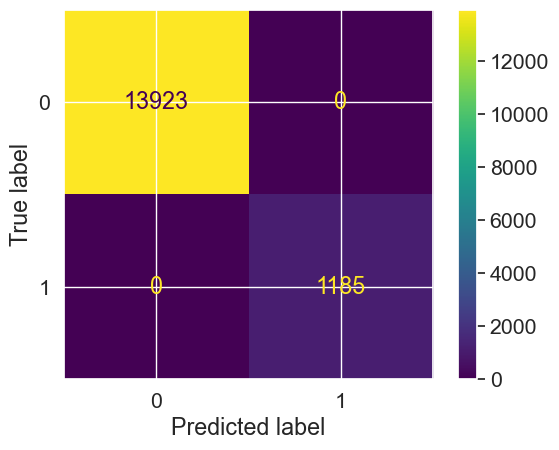

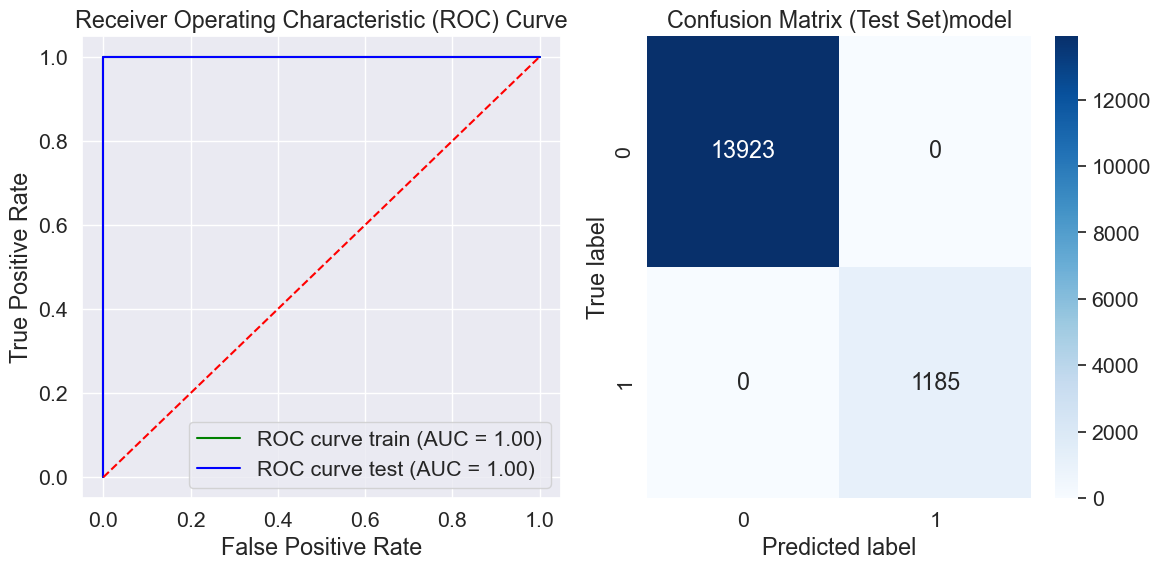

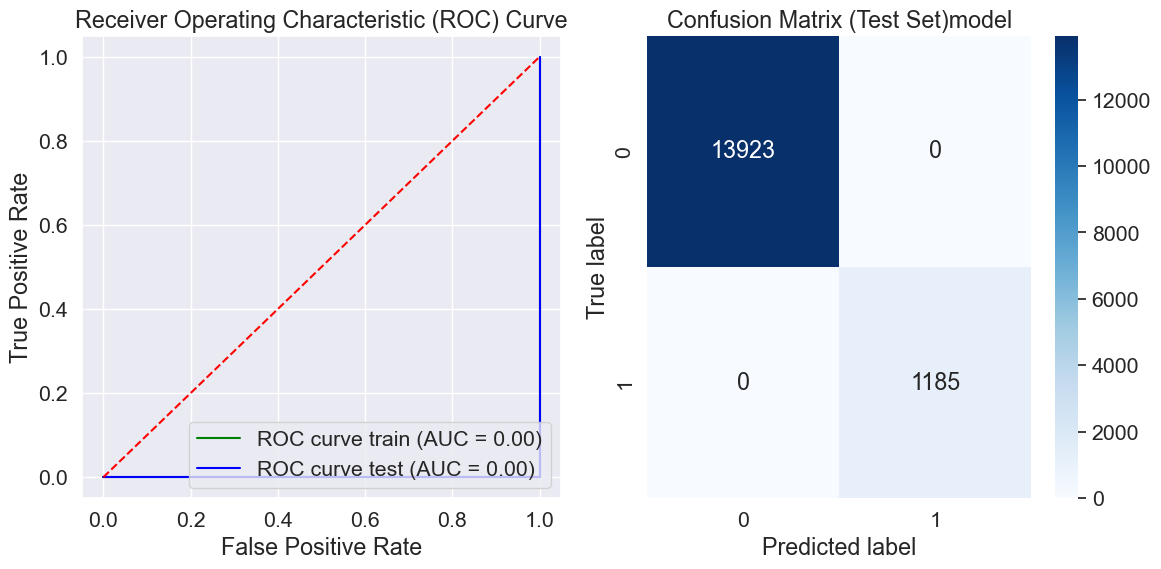

In [136]:
clf.predict_proba(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()
roc_curve__confusion_matrix(clf,1)
roc_curve__confusion_matrix(clf,0)

### Behavior loan clients

In [141]:
df_bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

# df bureau balance

In [74]:
df_bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [140]:
for col in df_bureau_balance.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)


variables SK_ID_BUREAU : []

variables MONTHS_BALANCE : ['Month of balance relative to application date (-1 means the freshest balance date)'
 '""Month of balance relative to application date (-1 means the information to the freshest monthly snapshot'
 'Month of balance relative to application date (-1 means the freshest balance date)']

variables STATUS : ['""Status of Credit Bureau loan during the month (active']


In [112]:
df_bureau_balance.STATUS.unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [142]:
df_bureau2 = df_bureau_balance.merge(df_bureau, how='left', on='SK_ID_BUREAU')

In [145]:
df_bureau2.loc[df_bureau2.STATUS =='5']

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
29354,5230570,-66,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29355,5230570,-67,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29356,5230570,-68,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29357,5230570,-69,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29358,5230570,-70,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27291903,5009756,-92,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291904,5009756,-93,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291905,5009756,-94,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291906,5009756,-95,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
df_bureau2.loc[df_bureau2.SK_ID_CURR == 100160]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
20534408,6481241,0,X,100160.0,Active,currency 1,-105.0,0.0,1564.0,NaN,NaN,0.0,373500.0,371403.0,NaN,0.0,Credit card,-25.0,22320.0
20534409,6481241,-1,0,100160.0,Active,currency 1,-105.0,0.0,1564.0,NaN,NaN,0.0,373500.0,371403.0,NaN,0.0,Credit card,-25.0,22320.0
20534410,6481241,-2,0,100160.0,Active,currency 1,-105.0,0.0,1564.0,NaN,NaN,0.0,373500.0,371403.0,NaN,0.0,Credit card,-25.0,22320.0
20534411,6481241,-3,X,100160.0,Active,currency 1,-105.0,0.0,1564.0,NaN,NaN,0.0,373500.0,371403.0,NaN,0.0,Credit card,-25.0,22320.0


In [164]:
df_bureau2.loc[(df_bureau2.STATUS =='5')]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
29354,5230570,-66,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29355,5230570,-67,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29356,5230570,-68,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29357,5230570,-69,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
29358,5230570,-70,5,440877.0,Closed,currency 1,-2780.0,0.0,-2475.0,-1957.0,17975.025,0.0,57937.5,0.0,0.0,0.0,Consumer credit,-1955.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27291903,5009756,-92,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291904,5009756,-93,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291905,5009756,-94,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27291906,5009756,-95,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
df_bureau2.loc[(df_bureau2.STATUS =='5') & (df_bureau2.CREDIT_ACTIVE == 'Active')]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
141858,5009749,0,5,367550.0,Active,currency 1,-468.0,0.0,1358.0,NaN,NaN,0.0,900000.0,782194.5,NaN,0.0,Consumer credit,-6.0,33790.5
141859,5009749,-1,5,367550.0,Active,currency 1,-468.0,0.0,1358.0,NaN,NaN,0.0,900000.0,782194.5,NaN,0.0,Consumer credit,-6.0,33790.5
141863,5009749,-5,5,367550.0,Active,currency 1,-468.0,0.0,1358.0,NaN,NaN,0.0,900000.0,782194.5,NaN,0.0,Consumer credit,-6.0,33790.5
141864,5009749,-6,5,367550.0,Active,currency 1,-468.0,0.0,1358.0,NaN,NaN,0.0,900000.0,782194.5,NaN,0.0,Consumer credit,-6.0,33790.5
141975,5009754,-12,5,367550.0,Active,currency 1,-1100.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Credit card,-389.0,33790.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27260359,5579494,-3,5,159719.0,Active,currency 1,-472.0,0.0,257.0,NaN,NaN,0.0,225000.0,96250.5,NaN,0.0,Consumer credit,-12.0,0.0
27260360,5579494,-4,5,159719.0,Active,currency 1,-472.0,0.0,257.0,NaN,NaN,0.0,225000.0,96250.5,NaN,0.0,Consumer credit,-12.0,0.0
27260361,5579494,-5,5,159719.0,Active,currency 1,-472.0,0.0,257.0,NaN,NaN,0.0,225000.0,96250.5,NaN,0.0,Consumer credit,-12.0,0.0
27260362,5579494,-6,5,159719.0,Active,currency 1,-472.0,0.0,257.0,NaN,NaN,0.0,225000.0,96250.5,NaN,0.0,Consumer credit,-12.0,0.0


In [149]:
for col in df_bureau2.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)


variables SK_ID_BUREAU : []

variables MONTHS_BALANCE : ['Month of balance relative to application date (-1 means the freshest balance date)'
 '""Month of balance relative to application date (-1 means the information to the freshest monthly snapshot'
 'Month of balance relative to application date (-1 means the freshest balance date)']

variables STATUS : ['""Status of Credit Bureau loan during the month (active']

variables SK_ID_CURR : ['ID of loan in our sample'
 '""ID of loan in our sample - one loan in our sample can have 0'
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

variables CREDIT_ACTIVE : ['Status of the Credit Bureau (CB) reported credits']

variables CREDIT_CURRENCY : ['Recoded currency of the Credit Bureau credit']

variables DAYS_CREDIT : ['How many days before current application did client apply for Credit Bureau credit']

variables CREDIT_DAY_OVERDUE : ['Number of days past due on CB credit at the ti

In [147]:
df_app_train3.loc[df_app_train3.TARGET == 1]

,TARGET,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_CHILDREN,DAYS_BIRTH,NAME_FAMILY_STATUS,DAYS_EMPLOYED,FLAG_OWN_CAR,FLAG_OWN_REALTY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,100002,202500.0,406597.5,24700.5,0,-9461,0,-637.000000,0,1,0.083037,0.262949,0.139376
42,1,100049,135000.0,288873.0,16258.5,0,-13384,1,-3597.000000,0,0,0.468208,0.674203,0.399676
138,1,100160,292500.0,675000.0,36747.0,0,-16667,1,-200.000000,0,1,0.320322,0.631961,0.289611
255,1,100295,225000.0,1019205.0,31032.0,1,-11356,0,-602.000000,1,0,0.262005,0.302394,0.463275
413,1,100477,112500.0,284400.0,22599.0,1,-13715,1,-151.000000,1,1,0.303693,0.616027,0.079060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307407,1,456140,261000.0,711454.5,47673.0,1,-11407,1,-1641.000000,1,1,0.766549,0.696695,0.624615
307433,1,456171,50400.0,113760.0,7731.0,0,-10873,0,-2356.487525,0,1,0.149808,0.182723,0.434733
307438,1,456176,171000.0,1436850.0,42142.5,0,-11275,0,-3085.000000,0,1,0.424250,0.727863,0.392774
307448,1,456186,207000.0,450000.0,32746.5,1,-9918,1,-3048.000000,0,0,0.073452,0.329708,0.360613


# installments payments

In [113]:
df_installments_payments[df_installments_payments.SK_ID_PREV == 2293789].sort_values('NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
950034,2293789,112427,0.0,1,-760.0,-760.0,6750.000,6750.000
2016001,2293789,112427,0.0,2,-737.0,-735.0,5727.510,5727.510
581063,2293789,112427,0.0,3,-735.0,-735.0,1022.490,1022.490
1760592,2293789,112427,0.0,4,-709.0,-712.0,5578.425,5578.425
1163955,2293789,112427,0.0,5,-712.0,-712.0,1171.575,1171.575
1458886,2293789,112427,0.0,6,-678.0,-692.0,7425.315,7425.315
469540,2293789,112427,0.0,7,-692.0,-692.0,224.685,224.685
881555,2293789,112427,0.0,8,-669.0,-669.0,7650.000,7650.000
3487802,2293789,112427,0.0,9,-648.0,-650.0,6913.215,6913.215
3366269,2293789,112427,0.0,10,-650.0,-650.0,286.785,286.785


In [114]:
sk_id_curr_instal = df_installments_payments.SK_ID_PREV
sk_id_curr_instal

0           1054186
1           1330831
2           2085231
3           2452527
4           2714724
             ...   
13605396    2186857
13605397    1310347
13605398    1308766
13605399    1062206
13605400    2448869
Name: SK_ID_PREV, Length: 13605401, dtype: int64

# df credit card

In [115]:
df_credit_card_balance.NAME_CONTRACT_STATUS.unique()

array(['Active', 'Completed', 'Demand', 'Signed', 'Sent proposal',
       'Refused', 'Approved'], dtype=object)

In [116]:
df_credit_card_balance.loc[df_credit_card_balance.NAME_CONTRACT_STATUS == 'Completed']

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
17,1039039,276642,-6,0.0,67500,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,33.0,Completed,0,0
18,2016842,302450,-3,0.0,0,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,2.0,Completed,0,0
46,1426111,116448,-7,0.0,0,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,15.0,Completed,0,0
53,1894367,113120,-1,0.0,0,0.0,2145.78,0.0,0.0,811.035,...,0.0,0.0,0.0,0,0.0,0.0,8.0,Completed,0,0
69,1079749,140209,-3,0.0,112500,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,35.0,Completed,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840224,1100883,160864,-14,0.0,90000,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,46.0,Completed,0,0
3840231,2636080,271437,-14,0.0,67500,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,60.0,Completed,0,0
3840251,1959181,120597,-15,0.0,67500,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,44.0,Completed,0,0
3840270,2733396,332633,-9,0.0,54000,0.0,0.00,0.0,0.0,0.000,...,0.0,0.0,0.0,0,0.0,0.0,11.0,Completed,0,0


In [117]:
df_credit_card_balance[df_credit_card_balance.SK_ID_PREV == 1039039].sort_values('MONTHS_BALANCE')[:50]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2250996,1039039,276642,-96,0.000,67500,0.0,0.0,0.0,0.0,581.04,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
317889,1039039,276642,-95,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
449377,1039039,276642,-94,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
3351706,1039039,276642,-93,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
2518866,1039039,276642,-92,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
1702154,1039039,276642,-91,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
1540974,1039039,276642,-90,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
39504,1039039,276642,-89,0.000,67500,0.0,0.0,0.0,0.0,0.00,...,0.000,0.000,0.0,0,0.0,0.0,6.0,Active,0,0
3190169,1039039,276642,-88,67364.820,67500,67500.0,67500.0,0.0,0.0,0.00,...,67364.820,67364.820,2.0,2,0.0,0.0,6.0,Active,0,0
1508435,1039039,276642,-87,68780.970,67500,67500.0,67500.0,0.0,0.0,3375.00,...,68780.970,68780.970,3.0,3,0.0,0.0,7.0,Active,0,0


In [118]:
df_credit_card_balance[df_credit_card_balance.SK_ID_PREV == 1039039].sort_values('MONTHS_BALANCE')[50:96]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2053427,1039039,276642,-46,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,-3810.42,-3810.42,0.0,0,0.0,0.0,33.0,Active,0,0
2943645,1039039,276642,-45,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
1898530,1039039,276642,-44,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
3838398,1039039,276642,-43,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
358299,1039039,276642,-42,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
347840,1039039,276642,-41,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
2982858,1039039,276642,-40,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
2661180,1039039,276642,-39,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
2769334,1039039,276642,-38,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0
2041251,1039039,276642,-37,0.0,67500,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0.0,0.0,33.0,Active,0,0


In [119]:
df_credit_card_balance[df_credit_card_balance.SK_ID_PREV == 2293789].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
577075,2293789,112427,-25,114972.255,450000,117000.0,117000.000,0.0,0.000,0.000,...,113626.755,113626.755,1.0,1,0.0,0.0,0.0,Active,0,0
2683006,2293789,112427,-24,112289.850,450000,0.0,0.000,0.0,0.000,5727.510,...,112289.850,112289.850,0.0,0,0.0,0.0,1.0,Active,0,0
62858,2293789,112427,-23,141702.165,450000,36000.0,36000.000,0.0,0.000,5578.425,...,142786.440,142786.440,2.0,2,0.0,0.0,2.0,Active,0,0
2823837,2293789,112427,-22,151761.915,450000,11250.0,11250.000,0.0,0.000,7425.315,...,150416.415,150416.415,1.0,1,0.0,0.0,3.0,Active,0,0
129169,2293789,112427,-21,158071.365,450000,6750.0,6750.000,0.0,0.000,6913.215,...,156725.865,156725.865,1.0,1,0.0,0.0,4.0,Active,0,0
3038365,2293789,112427,-20,155762.595,450000,0.0,0.000,0.0,0.000,7860.825,...,155762.595,155762.595,0.0,0,0.0,0.0,5.0,Active,0,0
266780,2293789,112427,-19,161730.585,450000,7200.0,7200.000,0.0,0.000,7738.245,...,160385.085,160385.085,1.0,1,0.0,0.0,6.0,Active,0,0
3269959,2293789,112427,-18,159609.060,450000,0.0,0.000,0.0,0.000,7608.465,...,159609.060,159609.060,0.0,0,0.0,0.0,7.0,Active,0,0
1221815,2293789,112427,-17,177205.725,450000,18000.0,18000.000,0.0,0.000,7936.920,...,174514.725,174514.725,2.0,2,0.0,0.0,8.0,Active,0,0
2920720,2293789,112427,-16,192846.780,450000,15750.0,15750.000,0.0,0.000,8512.740,...,190155.780,190155.780,2.0,2,0.0,0.0,9.0,Active,0,0


In [120]:
df_credit_card_balance[df_credit_card_balance.SK_ID_PREV == 2293789].sort_values('MONTHS_BALANCE').iloc[:,9:]

,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
577075,0.000,6750.0,6750.000,110250.000,113626.755,113626.755,1.0,1,0.0,0.0,0.0,Active,0,0
2683006,5727.510,6750.0,6750.000,107800.605,112289.850,112289.850,0.0,0,0.0,0.0,1.0,Active,0,0
62858,5578.425,14400.0,6974.685,140818.320,142786.440,142786.440,2.0,2,0.0,0.0,2.0,Active,0,0
2823837,7425.315,7650.0,7650.000,144456.300,150416.415,150416.415,1.0,1,0.0,0.0,3.0,Active,0,0
129169,6913.215,7200.0,7200.000,149064.075,156725.865,156725.865,1.0,1,0.0,0.0,4.0,Active,0,0
3038365,7860.825,7875.0,7875.000,149064.075,155762.595,155762.595,0.0,0,0.0,0.0,5.0,Active,0,0
266780,7738.245,8100.0,8100.000,153864.900,160385.085,160385.085,1.0,1,0.0,0.0,6.0,Active,0,0
3269959,7608.465,7650.0,7650.000,151719.030,159609.060,159609.060,0.0,0,0.0,0.0,7.0,Active,0,0
1221815,7936.920,9000.0,9000.000,167738.670,174514.725,174514.725,2.0,2,0.0,0.0,8.0,Active,0,0
2920720,8512.740,9000.0,9000.000,181504.755,190155.780,190155.780,2.0,2,0.0,0.0,9.0,Active,0,0


In [121]:
df_credit_card_balance.isna().mean()

SK_ID_PREV                    0.000000
SK_ID_CURR                    0.000000
MONTHS_BALANCE                0.000000
AMT_BALANCE                   0.000000
AMT_CREDIT_LIMIT_ACTUAL       0.000000
AMT_DRAWINGS_ATM_CURRENT      0.195249
AMT_DRAWINGS_CURRENT          0.000000
AMT_DRAWINGS_OTHER_CURRENT    0.195249
AMT_DRAWINGS_POS_CURRENT      0.195249
AMT_INST_MIN_REGULARITY       0.079482
AMT_PAYMENT_CURRENT           0.199981
AMT_PAYMENT_TOTAL_CURRENT     0.000000
AMT_RECEIVABLE_PRINCIPAL      0.000000
AMT_RECIVABLE                 0.000000
AMT_TOTAL_RECEIVABLE          0.000000
CNT_DRAWINGS_ATM_CURRENT      0.195249
CNT_DRAWINGS_CURRENT          0.000000
CNT_DRAWINGS_OTHER_CURRENT    0.195249
CNT_DRAWINGS_POS_CURRENT      0.195249
CNT_INSTALMENT_MATURE_CUM     0.079482
NAME_CONTRACT_STATUS          0.000000
SK_DPD                        0.000000
SK_DPD_DEF                    0.000000
dtype: float64

In [122]:
print('AMT_TOTAL_RECEIVABLE', df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'AMT_TOTAL_RECEIVABLE','Description'].values,
'\nAMT_BALANCE : ',df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'AMT_BALANCE','Description'].values)


AMT_TOTAL_RECEIVABLE ['Total amount receivable on the previous credit'] 
AMT_BALANCE :  ['Balance during the month of previous credit']


In [123]:
df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'AMT_RECEIVABLE_PRINCIPAL','Description'].values

array(['Amount receivable for principal on the previous credit'],
      dtype=object)

## Imbalanced class

In [124]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [125]:
print(imblearn.__version__)

0.11.0


In [126]:
rus = RandomUnderSampler(random_state=42)

In [127]:
X_res, y_res = rus.fit_resample(X, y)

In [128]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 22532, 1: 22532})


In [129]:

X = df_bureau_train2

y = df_bureau_train2.TARGET

X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [130]:
y_pred.shape, y_test.shape

((53994,), (6754,))

In [131]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3405
           1       1.00      1.00      1.00      3349

    accuracy                           1.00      6754
   macro avg       1.00      1.00      1.00      6754
weighted avg       1.00      1.00      1.00      6754



# df pos cash

In [76]:
df_POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [94]:
print('SK_DPD : ',df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'SK_DPD','Description'].values,
      '\nSK_DPD_DEF : ',df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'SK_DPD_DEF','Description'].values)


SK_DPD :  ['DPD (days past due) during the month of previous credit'
 'DPD (Days past due) during the month on the previous credit'] 
SK_DPD_DEF :  ['DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit'
 'DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit']


In [78]:
df_POS_CASH_balance[df_POS_CASH_balance.NAME_CONTRACT_STATUS == 'Completed']

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
42,1298869,210084,-41,48.0,0.0,Completed,0,0
52,1955907,134432,-34,4.0,0.0,Completed,0,0
124,2714240,302709,-38,16.0,0.0,Completed,0,0
172,1655882,288348,-47,10.0,0.0,Completed,0,0
200,2567983,448608,-33,16.0,0.0,Completed,0,0
...,...,...,...,...,...,...,...,...
10001293,1900633,301125,-25,12.0,0.0,Completed,0,0
10001307,1731058,165525,-19,6.0,0.0,Completed,0,0
10001316,2448283,226558,-19,6.0,0.0,Completed,0,0
10001350,2593362,198894,-20,12.0,0.0,Completed,0,0


In [79]:
df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'CNT_INSTALMENT','Description'].values

array(['Term of previous credit (can change over time)'], dtype=object)

# df previous application

In [64]:
df_previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [65]:
df_previous_application.CODE_REJECT_REASON.unique()

array(['XAP', 'HC', 'LIMIT', 'CLIENT', 'SCOFR', 'SCO', 'XNA', 'VERIF',
       'SYSTEM'], dtype=object)

In [66]:
df_previous_application.loc[df_previous_application.SK_ID_CURR == 100002].iloc[:,:10]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9


In [67]:
df_previous_application.loc[df_previous_application.SK_ID_CURR == 100002].iloc[:,10:20]

,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON
892077,Y,1,0.0,NaN,NaN,XAP,Approved,-606,XNA,XAP


In [68]:
df_previous_application.loc[df_previous_application.SK_ID_CURR == 100002].iloc[:,20:37]

,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
892077,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0


In [69]:
df_previous_application.iloc[:,:10]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9
...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9


In [70]:
df_previous_application.iloc[:,10:20]

,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON
0,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP
1,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP
2,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP
3,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP
4,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC
...,...,...,...,...,...,...,...,...,...,...
1670209,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP
1670210,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP
1670211,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP
1670212,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP


In [71]:
df_previous_application.iloc[:,20:30]

,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP
0,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle
1,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action
2,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high
3,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle
4,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high
...,...,...,...,...,...,...,...,...,...,...
1670209,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal
1670210,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle
1670211,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal
1670212,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal


In [72]:
df_app_train4 = df_app_train3.merge(df_previous_application,how = 'left' ,on ='SK_ID_CURR')


In [73]:
df_app_train4

,TARGET,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY_x,FLAG_OWN_CAR,FLAG_OWN_REALTY,ext_source_mean,debt_credit_ratio,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1,100002,0,25.920548,1.745205,24700.5,0,1,0.161787,2.007889,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,0,100003,0,45.931507,3.254795,35698.5,0,0,0.466757,4.790750,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,0,100003,0,45.931507,3.254795,35698.5,0,0,0.466757,4.790750,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,0,100003,0,45.931507,3.254795,35698.5,0,0,0.466757,4.790750,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,0,100004,0,52.180822,0.616438,6750.0,1,1,0.642739,2.000000,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254078,0,456255,0,46.180822,3.457534,49117.5,0,0,0.518984,4.285714,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-618.0,72.0,-558.0,-528.0,1.0
1254079,0,456255,0,46.180822,3.457534,49117.5,0,0,0.518984,4.285714,...,Connectivity,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1254080,0,456255,0,46.180822,3.457534,49117.5,0,0,0.518984,4.285714,...,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
1254081,0,456255,0,46.180822,3.457534,49117.5,0,0,0.518984,4.285714,...,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-756.0,294.0,-66.0,-64.0,0.0


In [74]:
df_app_train4.loc[df_app_train4.TARGET == 1]

,TARGET,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY_x,FLAG_OWN_CAR,FLAG_OWN_REALTY,ext_source_mean,debt_credit_ratio,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1,100002,0,25.920548,1.745205,24700.5,0,1,0.161787,2.007889,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
93,1,100031,0,51.298630,7.200000,27076.5,0,1,0.369592,8.711040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,1,100047,0,47.895890,3.457534,35028.0,0,1,0.313502,5.894222,...,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
155,1,100047,0,47.895890,3.457534,35028.0,0,1,0.313502,5.894222,...,XNA,24.0,high,Cash X-Sell: high,365243.0,-1437.0,-747.0,-1167.0,-1163.0,1.0
156,1,100047,0,47.895890,3.457534,35028.0,0,1,0.313502,5.894222,...,XNA,36.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253962,1,456225,0,56.558904,8.621918,19975.5,0,1,0.612708,1.320000,...,XNA,24.0,high,Cash X-Sell: high,365243.0,-912.0,-222.0,-342.0,-334.0,1.0
1253996,1,456233,0,45.126027,0.783562,23089.5,0,1,0.506604,2.316800,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-277.0,53.0,365243.0,365243.0,1.0
1253997,1,456233,0,45.126027,0.783562,23089.5,0,1,0.506604,2.316800,...,Consumer electronics,0.0,XNA,Card Street,-241.0,-204.0,365243.0,365243.0,365243.0,0.0
1254073,1,456254,0,32.769863,13.112329,20205.0,0,1,0.587593,2.164368,...,Consumer electronics,16.0,low_normal,POS household with interest,365243.0,-247.0,203.0,365243.0,365243.0,1.0


<AxesSubplot:>

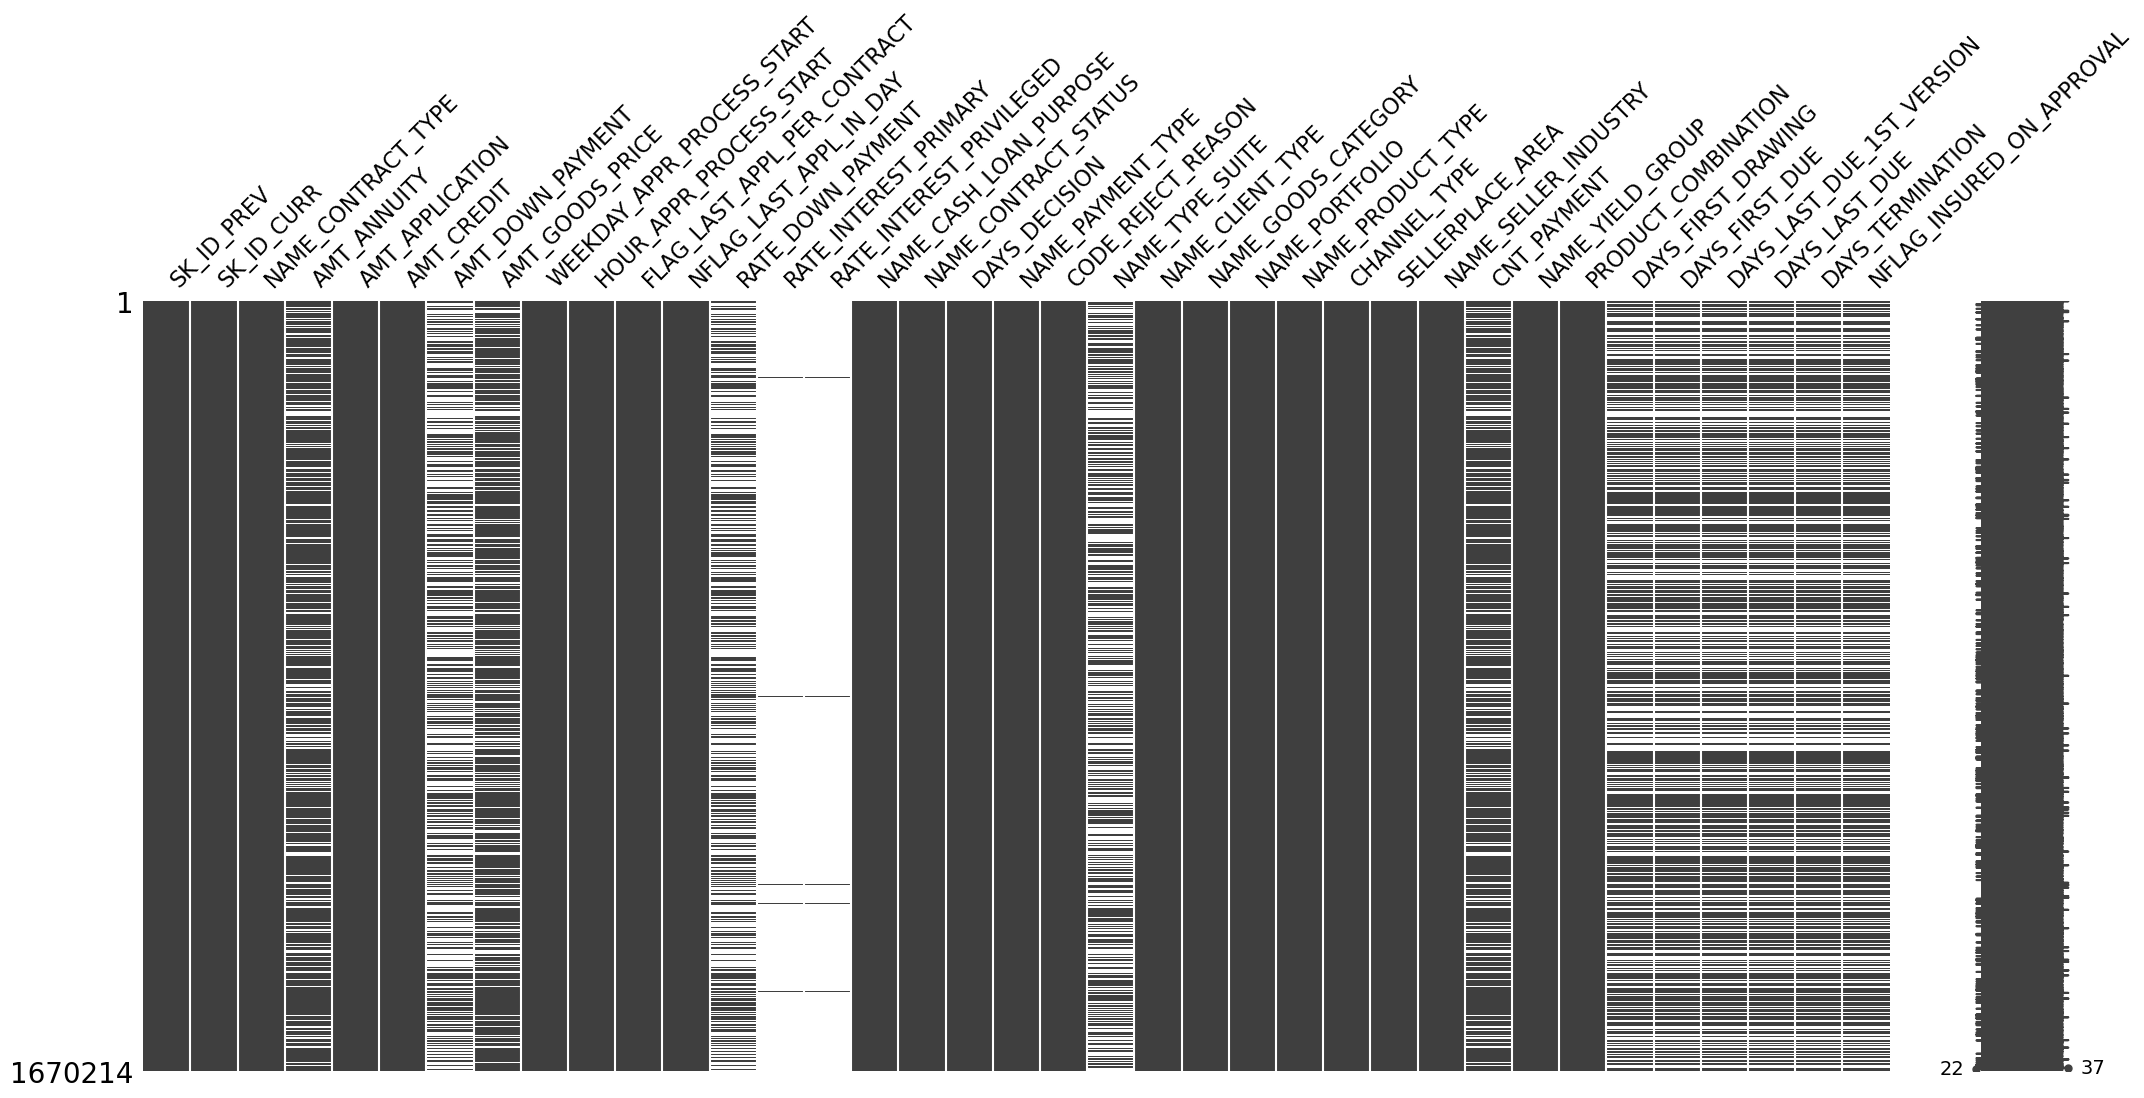

In [81]:
msno.matrix(df_previous_application)

In [75]:
for col in df_previous_application.columns:
    print(f'\nvariables {col} :', df_HomeCredit_description.loc[df_HomeCredit_description.Row == col,'Description'].values)


variables SK_ID_PREV : []

variables SK_ID_CURR : ['ID of loan in our sample'
 '""ID of loan in our sample - one loan in our sample can have 0'
 'ID of loan in our sample' 'ID of loan in our sample'
 'ID of loan in our sample' 'ID of loan in our sample']

variables NAME_CONTRACT_TYPE : ['Identification if loan is cash or revolving'
 '""Contract product type (Cash loan']

variables AMT_ANNUITY : ['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']

variables AMT_APPLICATION : ['For how much credit did client ask on the previous application']

variables AMT_CREDIT : ['Credit amount of the loan'
 '""Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for']

variables AMT_DOWN_PAYMENT : ['Down payment on the previous application']

variables AMT_GOODS_PRICE : ['For consumer loans it is the price of the goods for which the loan is given'

In [82]:
df_previous_application.NFLAG_INSURED_ON_APPROVAL.unique()

array([ 0.,  1., nan])

In [83]:
df_previous_application.CODE_REJECT_REASON.unique()

array(['XAP', 'HC', 'LIMIT', 'CLIENT', 'SCOFR', 'SCO', 'XNA', 'VERIF',
       'SYSTEM'], dtype=object)

In [86]:
df_previous_application.loc[df_previous_application.CODE_REJECT_REASON == 'CLIENT']

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
41,1366380,247572,Consumer loans,NaN,17950.5,17950.5,0.0,17950.5,MONDAY,19,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
97,1935914,191576,Consumer loans,NaN,23400.0,23400.0,NaN,23400.0,SATURDAY,9,...,Consumer electronics,NaN,XNA,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
98,1457539,307992,Consumer loans,NaN,113215.5,113215.5,0.0,113215.5,SUNDAY,12,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
152,1763186,393157,Consumer loans,NaN,62860.5,62860.5,0.0,62860.5,FRIDAY,15,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
182,2284847,454600,Consumer loans,NaN,27666.0,27666.0,0.0,27666.0,THURSDAY,16,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669871,1113831,392418,Consumer loans,NaN,77872.5,77872.5,0.0,77872.5,MONDAY,13,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1669906,2282462,380974,Consumer loans,NaN,58455.0,58455.0,0.0,58455.0,MONDAY,10,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1669921,1278516,445150,Consumer loans,NaN,17005.5,17005.5,NaN,17005.5,SATURDAY,11,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1669946,2655856,244971,Consumer loans,NaN,21555.0,21555.0,0.0,21555.0,WEDNESDAY,17,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df_previous_application.loc[df_previous_application.CODE_REJECT_REASON == 'XAP']

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [85]:
df_previous_application.loc[df_previous_application.CODE_REJECT_REASON == 'HC']

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
19,1173070,199178,Cash loans,4666.500,45000.0,49455.0,NaN,45000.0,SATURDAY,16,...,XNA,18.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
20,1506815,166490,Cash loans,25454.025,450000.0,491580.0,NaN,450000.0,MONDAY,6,...,XNA,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
22,1172842,302212,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
23,1172937,302212,Cash loans,39475.305,1129500.0,1277104.5,NaN,1129500.0,THURSDAY,5,...,XNA,54.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670161,2461432,388833,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,20,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1670184,1458393,279524,Cash loans,48458.025,1575000.0,1762110.0,NaN,1575000.0,WEDNESDAY,10,...,XNA,60.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1670191,1755809,122569,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,WEDNESDAY,12,...,Consumer electronics,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1670193,1120445,179433,Revolving loans,NaN,0.0,0.0,NaN,NaN,SUNDAY,13,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df_app_train4.loc[df_app_train4.SK_ID_CURR == 100002].iloc[:,:20]

,TARGET,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY_x,FLAG_OWN_CAR,FLAG_OWN_REALTY,ext_source_mean,debt_credit_ratio,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT
0,1,100002,0,25.920548,1.745205,24700.5,0,1,0.161787,2.007889,1038818.0,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9.0,Y


In [79]:
df_app_train4.loc[df_app_train4.SK_ID_CURR == 100002].iloc[:,20:40]

,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,1.0,0.0,NaN,NaN,XAP,Approved,-606.0,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest


In [80]:
df_app_train4.loc[df_app_train4.SK_ID_CURR == 100002].iloc[:,40:47]

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,365243.0,-565.0,125.0,-25.0,-17.0,0.0


In [95]:
'NAME_YIELD_GROUP : ',df_HomeCredit_description.loc[df_HomeCredit_description.Row == 'NAME_YIELD_GROUP','Description'].values

('NAME_YIELD_GROUP : ',
 array(['Grouped interest rate into small medium and high of the previous application'],
       dtype=object))

In [81]:
df_previous_application.isna().mean()

SK_ID_PREV                     0.000000e+00
SK_ID_CURR                     0.000000e+00
NAME_CONTRACT_TYPE             0.000000e+00
AMT_ANNUITY                    2.228667e-01
AMT_APPLICATION                0.000000e+00
AMT_CREDIT                     5.987257e-07
AMT_DOWN_PAYMENT               5.363648e-01
AMT_GOODS_PRICE                2.308177e-01
WEEKDAY_APPR_PROCESS_START     0.000000e+00
HOUR_APPR_PROCESS_START        0.000000e+00
FLAG_LAST_APPL_PER_CONTRACT    0.000000e+00
NFLAG_LAST_APPL_IN_DAY         0.000000e+00
RATE_DOWN_PAYMENT              5.363648e-01
RATE_INTEREST_PRIMARY          9.964370e-01
RATE_INTEREST_PRIVILEGED       9.964370e-01
NAME_CASH_LOAN_PURPOSE         0.000000e+00
NAME_CONTRACT_STATUS           0.000000e+00
DAYS_DECISION                  0.000000e+00
NAME_PAYMENT_TYPE              0.000000e+00
CODE_REJECT_REASON             0.000000e+00
NAME_TYPE_SUITE                4.911975e-01
NAME_CLIENT_TYPE               0.000000e+00
NAME_GOODS_CATEGORY            0